In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# # # # create folder to write data to
# CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_Rectified')
# HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'SOLO_FINALNORMALIZATION')
# os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

Mounted at /content/gdrive


In [ ]:
## Author: Lishuo Pan 2020/4/18
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pdb
import torchvision 
from matplotlib.patches import Rectangle
import random


class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, path):
      self.images_h5 = h5py.File(path[0],mode='r')
      self.image_data = self.images_h5.get('data')
      self.mask_h5 = h5py.File(path[1],mode='r')
      self.mask_data = self.mask_h5.get('data')
      self.bbox_data = np.load(path[3], allow_pickle=True)
      self.label_data = np.load(path[2], allow_pickle=True)
      #self.transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
      self.totensor = transforms.ToTensor()
      self.pad = 11
      self.target_h = 800
      self.target_w = 1088
      self.resize_h = self.target_h
      self.resize_w = self.target_w - 2*self.pad

      self.struct_mask = self.grouping_mask_label(self.label_data, self.mask_data)
    #   self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


      
    # output:
        # transed_img
        # label
        # transed_mask
        # transed_bbox

    def grouping_mask_label(self,labels, masks):
        mask_group =[]
        items = 0
        for i in range(len(labels)):        
            mask_group.append(masks[items:items+len(labels[i])])

            items += len(labels[i])
        return np.array(mask_group)
    
    # def grouping_mask_label(self,labels, masks):
    #     final_mask =[]
    #     items = 0
    #     for i in range(len(labels)):        
    #         if len(labels[i]) > 1:
    #             final_mask.append(masks[items:items+len(labels[i])])
    #         else:
    #             final_mask.append(np.asarray([masks[items]]))
    #         items = items + len(labels[i])
    #     return np.array(final_mask)

    def __getitem__(self, index):
        # TODO: __getitem__
        # check flag
        image_data = self.image_data[index]
        label_data = self.label_data[index]
        bbox_data = self.bbox_data[index]
        mask_data = self.mask_data[index]
        mask_list = self.struct_mask[index]
        image_data,mask_list ,bbox_data = self.pre_process_batch(image_data,mask_list,bbox_data)
        # print(label_data)
        # label_data = self.totensor(label_data)
        #assert image_data.shape == (3, 800, 1088)
        #print("Initial List shape",bbox_data.shape[0])
        #print("Masked List shape",mask_list.shape[0])
        # if bbox_data.shape[0] == mask_list.shape[0]:
            #print("Success!!")
        #assert bbox_data.shape[0] == mask_list.shape[0]

        # for j in range(len(label_data[i])):
        #         print("SCALE",scale)
        #         #bbox = bbox.copy().astype(float)
        #         bbox_data[i][j][0] = np.multiply(bbox_data[i][j][0], x_scale )
        #         bbox_data[i][j][1] = np.multiply(bbox_data[i][j][1], y_scale )
        #         bbox_data[i][j][2] = np.multiply(bbox_data[i][j][2], x_scale)
        #         bbox_data[i][j][3] = np.multiply(bbox_data[i][j][3], y_scale )

        return image_data,label_data,mask_list,bbox_data

    def __len__(self):
        return len(self.image_data)
    
    # This function take care of the pre-process of img,mask,bbox
    # in the input mini-batch
    # input:
        # img: 3*300*400
        # mask: 3*300*400
        # bbox: n_box*4
    def pre_process_batch(self, img, mask, bbox):
        # TODO: image preprocess
        img = img.astype('float64')
        img = self.totensor(img)
        bbox1 =np.zeros(bbox.shape)
        mask = mask.astype('float64')
        mask = self.totensor(mask)
        ori_h, ori_w = 300, 400
        h_zoom_ratio, w_zoom_ratio = self.resize_h / ori_h, self.resize_w / ori_w
	

        img = img.permute(1, 2, 0)
        #print("Image shape 1",img.shape)
        img = img.permute(0, 2, 1)
        #print("Image shape 2",img.shape)
        img = F.interpolate(img, size=800)
        img = img.permute(0, 2, 1)
        img = F.interpolate(img, size=1066)

        
        img = torchvision.transforms.functional.normalize(img,[0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        img = torch.nn.functional.pad(img,(11,11))
        #Interpolating the mask
        mask = mask.permute(1, 2, 0)
        mask = mask.permute(0, 2, 1)
        mask = F.interpolate(mask, size=800)
        mask = mask.permute(0, 2, 1)
        mask = F.interpolate(mask, size=1066)
        mask = torch.nn.functional.pad(mask,(11,11))
        # # check flag
        # if img.shape == (3, 800, 1088):
          #print("Works")
        
        #assert img.shape == (3, 800, 1088)

        #assert bbox.shape[0] == mask.shape[0]
        x_scale = 800 / 300
        y_scale = 1066 / 400
        #print("BBOX SHAPE",bbox.shape)
        # pdb.set_trace()

        # bbox1[:, 0] = bbox[:, 0] * w_zoom_ratio + self.pad
        # bbox1[:, 1] = bbox[:, 1] * h_zoom_ratio
        # bbox1[:, 2] = bbox[:, 2] * w_zoom_ratio + self.pad
        # bbox1[:, 3] = bbox[:, 3] * h_zoom_ratio

        bbox1[:, 0] = bbox[:, 0] * 2.665  + self.pad
        bbox1[:, 1] = bbox[:, 1] * 2.6667
        bbox1[:, 2] = bbox[:, 2] * 2.665 + self.pad
        bbox1[:, 3] = bbox[:, 3] * 2.6667

        return img, mask, bbox1


class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers      

    # output:
        # img: (bz, 3, 800, 1088)
        # label_list: list, len:bz, each (n_obj,)
        # transed_mask_list: list, len:bz, each (n_obj, 800,1088)
        # transed_bbox_list: list, len:bz, each (n_obj, 4)
        # img: (bz, 3, 300, 400)
    def collect_fn(self, batch):
        # TODO: collect_fn
        transed_img_list = []
        label_list = []
        transed_mask_list = []
        transed_bbox_list = []
        for transed_img, label, transed_mask, transed_bbox in batch:
            transed_img_list.append(transed_img)
            label_list.append(label)
            transed_mask_list.append(transed_mask)
            transed_bbox_list.append(transed_bbox)
        return torch.stack(transed_img_list, dim=0), label_list, transed_mask_list, transed_bbox_list
      

    def loader(self):
      return DataLoader(self.dataset, batch_size=self.batch_size,shuffle=True, collate_fn=self.collect_fn)

In [ ]:
import torchvision
import torch


def Resnet50Backbone(checkpoint_file=None, device="cpu", eval=True):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)

    if eval == True:
        model.eval()

    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    resnet50_fpn = model.backbone

    if checkpoint_file:
        checkpoint = torch.load(checkpoint_file)

        resnet50_fpn.load_state_dict(checkpoint['backbone'])

    return resnet50_fpn

if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    resnet50_fpn = Resnet50Backbone(device=device)
    # backbone = Resnet50Backbone('checkpoint680.pth')
    E = torch.ones([2,3,800,1088], device=device)
    backout = resnet50_fpn(E)
    print(backout.keys())
    print(backout["0"].shape)
    print(backout["1"].shape)
    print(backout["2"].shape)
    print(backout["3"].shape)
    print(backout["pool"].shape)

    # print(torch.nn.functional.interpolate(backout["pool"],size=2).shape) ## check this

    # print(torch.cat(backout["pool"],))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



odict_keys(['0', '1', '2', '3', 'pool'])
torch.Size([2, 256, 200, 272])
torch.Size([2, 256, 100, 136])
torch.Size([2, 256, 50, 68])
torch.Size([2, 256, 25, 34])
torch.Size([2, 256, 13, 17])


# solo_head.py

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import ndimage
#from dataset import *
from functools import partial
from scipy.ndimage import measurements

class SOLOHead(nn.Module):
    def __init__(self,
                 num_classes,
                 in_channels=256,
                 seg_feat_channels=256,
                 stacked_convs=7,
                 strides=[8, 8, 16, 32, 32],
                 scale_ranges=((1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)),
                 epsilon=0.2,
                 num_grids=[40, 36, 24, 16, 12],
                 cate_down_pos=0,
                 with_deform=False,
                 mask_loss_cfg=dict(weight=3),
                 cate_loss_cfg=dict(gamma=2,
                                alpha=0.25,
                                weight=1),
                 postprocess_cfg=dict(cate_thresh=0.2,
                                      ins_thresh=0.5,
                                      pre_NMS_num=50,
                                      keep_instance=5,
                                      IoU_thresh=0.5)):
        super(SOLOHead, self).__init__()
        self.num_classes = num_classes
        self.seg_num_grids = num_grids
        self.cate_out_channels = self.num_classes - 1
        self.in_channels = in_channels
        self.seg_feat_channels = seg_feat_channels
        self.stacked_convs = stacked_convs
        self.strides = strides
        self.epsilon = epsilon
        self.cate_down_pos = cate_down_pos
        self.scale_ranges = scale_ranges
        self.with_deform = with_deform

        self.mask_loss_cfg = mask_loss_cfg
        self.cate_loss_cfg = cate_loss_cfg
        self.postprocess_cfg = postprocess_cfg
        # initialize the layers for cate and mask branch, and initialize the weights
        self._init_layers()
        self._init_weights()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # check flag
        # assert len(self.ins_head) == self.stacked_convs
        # assert len(self.cate_head) == self.stacked_convs
        # assert len(self.ins_out_list) == len(self.strides)

    # This function build network layer for cate and ins branch
    # it builds 4 self.var
        # self.cate_head is nn.ModuleList 7 inter-layers of conv2d
        # self.ins_head is nn.ModuleList 7 inter-layers of conv2d
        # self.cate_out is 1 out-layer of conv2d
        # self.ins_out_list is nn.ModuleList len(self.seg_num_grids) out-layers of conv2d, one for each fpn_feat
    def _init_layers(self):
        ## TODO initialize layers: stack intermediate layer and output layer
        # define groupnorm
        num_groups = 32
        # initial the two branch head modulelist
        self.cate_head = nn.ModuleList([nn.Sequential(nn.Conv2d(256,256,3,stride=1,padding=1,bias=False),nn.GroupNorm(num_groups,256),nn.ReLU()) for i in range(7)])
        self.cate_out = nn.Sequential(nn.Conv2d(256,3,3,padding=1,bias=True),nn.Sigmoid())
        self.ins_head = nn.ModuleList([nn.Sequential(nn.Conv2d(258,256,3,stride=1,padding=1,bias=False),nn.GroupNorm(num_groups,256),nn.ReLU()),nn.Sequential(nn.Conv2d(256,256,3,stride=1,padding=1,bias=False),nn.GroupNorm(num_groups,256),nn.ReLU()),nn.Sequential(nn.Conv2d(256,256,3,stride=1,padding=1,bias=False),nn.GroupNorm(num_groups,256),nn.ReLU()),nn.Sequential(nn.Conv2d(256,256,3,stride=1,padding=1,bias=False),nn.GroupNorm(num_groups,256),nn.ReLU()),nn.Sequential(nn.Conv2d(256,256,3,stride=1,padding=1,bias=False),nn.GroupNorm(num_groups,256),nn.ReLU()),nn.Sequential(nn.Conv2d(256,256,3,stride=1,padding=1,bias=False),nn.GroupNorm(num_groups,256),nn.ReLU()),nn.Sequential(nn.Conv2d(256,256,3,stride=1,padding=1,bias=False),nn.GroupNorm(num_groups,256),nn.ReLU())])
        self.ins_out_list = nn.ModuleList([nn.Sequential(nn.Conv2d(256,numGrid**2,1,padding=0,bias=True),nn.Sigmoid()) for numGrid in self.seg_num_grids])

    # This function initialize weights for head network
    def _init_weights(self):
        ## TODO: initialize the weights
        i = 0
        j = 0
        while i < len(self.cate_head) or j < len(self.ins_head):
            if i < len(self.cate_head):
                nn.init.xavier_uniform_(self.cate_head[i][0].weight)
                
                i = i+1
            if j < len(self.ins_head):
                nn.init.xavier_uniform_(self.ins_head[j][0].weight)
                # self.ins_head[j][0].weight.to(self.device)
                j = j+1
        for k in range(len(self.ins_out_list)):
            nn.init.xavier_uniform_(self.ins_out_list[k][0].weight)


    # Forward function should forward every levels in the FPN.
    # this is done by map function or for loop
    # Input:
        # fpn_feat_list: backout_list of resnet50-fpn#             #print('H_FEAT',H_FEAT)
#             print('W_FEAT',W_FEAT)
#             print('FRAC_H',FRAC_H)
#             print('FRAC_W',FRAC_W)
    # Output:
        # if eval = False
            # cate_pred_list: list, len(fpn_level), each (bz,C-1,S,S)
            # ins_pred_list: list, len(fpn_level), each (bz, S^2, 2H_feat, 2W_feat)
        # if eval==True
            # cate_pred_list: list, len(fpn_level), each (bz,S,S,C-1) / after point_NMS
            # ins_pred_list: list, len(fpn_level), each (bz, S^2, Ori_H, Ori_W) / after upsampling
    def forward(self, fpn_feat_list, eval=False):
#         for i in range(len(fpn_feat_list)):
# #             print('NEW',new_fpn_list[i].shape)
#             print('OLD',fpn_feat_list[i].shape)
#         print()
        new_fpn_list = self.NewFPN(fpn_feat_list) # stride[8,8,16,32,32]
        # for i in range(len(new_fpn_list)):
            #print('NEW',new_fpn_list[i].shape)
        #print()
        # assert new_fpn_list[0].shape[1:] == (256,100,136)
        quart_shape = [new_fpn_list[0].shape[-2]*2, new_fpn_list[0].shape[-1]*2]  # stride: 4
#         print('Quart Shape',quart_shape)
        # TODO: use MultiApply to compute cate_pred_list, ins_pred_list. Parallel w.r.t. feature level.
        cate_pred_list, ins_pred_list = self.MultiApply(self.forward_single_level,
                                                        new_fpn_list,
                                                        list(range(len(new_fpn_list))),
                                                        eval = eval,
                                                        upsample_shape = quart_shape)
        
        # assert len(new_fpn_list) == len(self.seg_num_grids)

        # assert cate_pred_list[1].shape[1] == self.cate_out_channels
        # assert ins_pred_list[1].shape[1] == self.seg_num_grids[1]**2
        # assert cate_pred_list[1].shape[2] == self.seg_num_grids[1]
        return cate_pred_list, ins_pred_list

    # This function upsample/downsample the fpn level for the network
    # In paper author change the original fpn level resolution
    # Input:
        # fpn_feat_list, list, len(FPN), stride[4,8,16,32,64]
    # Output:
    # new_fpn_list, list, len(FPN), stride[8,8,16,32,32]
    def NewFPN(self, fpn_feat_list):

        new_fpn_list = fpn_feat_list
        new_fpn_list[0] = torch.nn.functional.interpolate(fpn_feat_list[0],scale_factor=0.5,mode='bilinear')
        new_fpn_list[-1] = torch.nn.functional.interpolate(fpn_feat_list[-1],size=(25,34),mode='bilinear')
        return new_fpn_list

    # This function forward a single level of fpn_feat map through the network
    # Input:
        # fpn_feat: (bz, fpn_channels(256), H_feat, W_feat)
        # idx: indicate the fpn level idx, num_grids idx, the ins_out_layer idx
    # Output:
        # if eval==False
            # cate_pred: (bz,C-1,S,S)
            # ins_pred: (bz, S^2, 2H_feat, 2W_feat)
        # if eval==True
            # cate_pred: (bz,S,S,C-1) / after point_NMS
            # ins_pred: (bz, S^2, Ori_H/4, Ori_W/4) / after upsampling
    def forward_single_level(self, fpn_feat, idx, eval=False, upsample_shape=None):

        cate_pred = fpn_feat.cuda()
        ins_pred = fpn_feat.cuda()
        # num_grid = self.seg_num_grids[idx]  # current level grid
        #print('category before pass: ',cate_pred.shape)

        # for i,layer in enumerate(self.cate_head):
        #     cate_pred = layer(cate_pred)
        cate_pred = torch.nn.functional.interpolate(cate_pred,size=self.seg_num_grids[idx], mode='bilinear')
        cate_pred = self.cate_head[0](cate_pred)
        cate_pred = self.cate_head[1](cate_pred)
        cate_pred = self.cate_head[2](cate_pred)
        cate_pred = self.cate_head[3](cate_pred)
        cate_pred = self.cate_head[4](cate_pred)
        cate_pred = self.cate_head[5](cate_pred)
        cate_pred = self.cate_head[6](cate_pred)
            
        cate_pred = self.cate_out(cate_pred)
        #print('category tensor after pass: ',cate_pred.shape)
        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        bz = fpn_feat.shape[0]
        H_FEAT = fpn_feat.shape[2]
        W_FEAT = fpn_feat.shape[3]
        yv, xv = torch.meshgrid([torch.linspace(-1,1,H_FEAT), torch.linspace(-1,1,W_FEAT)])
        yv = yv.to(self.device)
        xv = xv.to(self.device)
        yv = yv.view(1,1,H_FEAT,W_FEAT)
        yv = torch.cat([yv]*bz)
        xv = xv.view(1,1,H_FEAT,W_FEAT)
        xv = torch.cat([xv]*bz)
        #print('xv: ',xv.shape)
        #print('yv: ',yv.shape)

        ins_pred = torch.cat([ins_pred,xv,yv],1)
#         torch.cat([ins_pred[1],xv,yv],0)
        #print('ins_pred tensor after concat: ', ins_pred.shape)

        # for i,layer in enumerate(self.ins_head):
        #     ins_pred = layer(ins_pred)
        
        ins_pred = self.ins_head[0](ins_pred)
        ins_pred = self.ins_head[1](ins_pred)
        ins_pred = self.ins_head[2](ins_pred)
        ins_pred = self.ins_head[3](ins_pred)
        ins_pred = self.ins_head[4](ins_pred)
        ins_pred = self.ins_head[5](ins_pred)
        ins_pred = self.ins_head[6](ins_pred)
        
        ins_pred = self.ins_out_list[idx](ins_pred)
        #print('ins_pred after forward pass: ', ins_pred.shape)
        
        # in inference time, upsample the pred to (ori image size/4)
        if eval == True:
            ## TODO resize ins_pred            
            cate_pred = torch.nn.functional.interpolate(cate_pred,size=self.seg_num_grids[idx],mode='bilinear')
            cate_pred = self.points_nms(cate_pred).permute(0,2,3,1)
            #print('eval=false modification for cat: ',cate_pred.shape)
            
            # ORI_H = 800
            # ORI_W = 1088
            # FRAC_H = (ORI_H/4)/H_FEAT
            # FRAC_W= (ORI_W/4)/W_FEAT
            #print('eval=false modification for ins (BEFORE): ', ins_pred.shape)
            ins_pred = torch.nn.functional.interpolate(ins_pred,size=upsample_shape, mode='bilinear')
            #print('eval=false modification for ins (AFTER): ', ins_pred.shape)

        # check flag
        if eval == False:
            # cate_pred = torch.nn.functional.interpolate(cate_pred,size=self.seg_num_grids[idx], mode='bilinear')
            #print('eval=false modification for cat: ',cate_pred.shape)
            
            #print('eval=false modification for ins (BEFORE): ', ins_pred.shape)
            ins_pred = torch.nn.functional.interpolate(ins_pred,size=(2*H_FEAT,2*W_FEAT), mode='bilinear')
            #print('eval=false modification for ins (AFTER): ', ins_pred.shape)
            
            # assert cate_pred.shape[1:] == (3, num_grid, num_grid)
            # assert ins_pred.shape[1:] == (num_grid**2, fpn_feat.shape[2]*2, fpn_feat.shape[3]*2)
        else:
            pass
        #print()
        return cate_pred, ins_pred

    # Credit to SOLO Author's code
    # This function do a NMS on the heat map(cate_pred), grid-level
    # Input:
        # heat: (bz,C-1, S, S)
    # Output:
        # (bz,C-1, S, S)
    def points_nms(self, heat, kernel=2):
        # kernel must be 2
        hmax = nn.functional.max_pool2d(
            heat, (kernel, kernel), stride=1, padding=1)
        keep = (hmax[:, :, :-1, :-1] == heat).float()
        return heat * keep

    def loss(self,cate_pred_list,ins_pred_list,ins_gts_list,ins_ind_gts_list,cate_gts_list):
        ins_gts = [torch.cat([ins_labels_level_img[ins_ind_labels_level_img,...]for ins_labels_level_img,ins_ind_labels_level_img in zip(ins_labels_level,ins_ind_labels_level)],0)\
                  for ins_labels_level,ins_ind_labels_level in zip(zip(*ins_gts_list),zip(*ins_ind_gts_list))]
        ins_preds = [torch.cat([ins_preds_level_img[ins_ind_labels_level_img,...]\
                               for ins_preds_level_img,ins_ind_labels_level_img in\
                               zip(ins_preds_level,ins_ind_labels_level)],0)\
                    for ins_preds_level,ins_ind_labels_level in\
                    zip(ins_pred_list,zip(*ins_ind_gts_list))]
        cate_gts = [torch.cat([cate_gts_level_img.flatten()\
                               for cate_gts_level_img in cate_gts_level])\
                    for cate_gts_level in zip(*cate_gts_list)]
        cate_gts = torch.cat(cate_gts)
        cate_preds = [cate_pred_level.permute(0,2,3,1).reshape(-1,self.cate_out_channels)\
                      for cate_pred_level in cate_pred_list]
        cate_preds = torch.cat(cate_preds,0)

        ##Loss Computation
        cate_loss = self.FocalLoss(cate_preds,cate_gts)
        mask_loss = 0
        # start = time.time()
        total_masks = 0.0000001
        for level in range(len(ins_preds)):
          level_mask_loss = 0
          for i in range(len(ins_preds[level])):
            level_mask_loss += 1-self.DiceLoss(ins_preds[level][i].cpu(),ins_gts[level][i].cpu())
          total_masks += ins_preds[level].size(0)
          mask_loss += level_mask_loss
        mask_loss /= total_masks
        # print('Time Taken={}'.format(time.time()-start))
        total_loss = cate_loss + self.mask_loss_cfg['weight']*mask_loss
        return cate_loss,mask_loss,total_loss
        


    # This function compute the DiceLoss
    # Input:
        # mask_pred: (2H_feat, 2W_feat)
        # mask_gt: (2H_feat, 2W_feat)
    # Output: dice_loss, scalar
    def DiceLoss(self, mask_pred, mask_gt):
        ## TODO: compute DiceLoss
        # print(mask_pred.is_cuda,mask_gt.is_cuda)
        DL = 2*torch.sum(mask_pred*mask_gt)/(torch.sum(mask_pred*mask_pred)+torch.sum(mask_gt*mask_gt))
        return DL

    # This function compute the cate loss
    # Input:
        # cate_preds: (num_entry, C-1)
        # cate_gts: (num_entry,)
    # Output: focal_loss, scalar
    def FocalLoss(self, cate_preds, cate_gts):
        ## TODO: compute focalloss
        # start = time.time()
        pt = torch.flatten(cate_preds).cpu()
        cate_gts = cate_gts.reshape(cate_gts.size(0),1)
        cate_onehot_gts = (cate_gts.cpu() == torch.arange(self.cate_out_channels+1).reshape(1,self.cate_out_channels+1)).float()
        cate_onehot_gts = cate_onehot_gts[:,1:]
        y = torch.flatten(cate_onehot_gts)
        # print(pt.is_cuda,y.is_cuda,sep='\n')
        focal_loss = -0.25*y*(1-pt)**2*torch.log(pt)-0.75*(1-y)*(1-(1-pt))**2*torch.log(1-pt)
        focal_loss /= focal_loss.size(0)
        FL = torch.sum(focal_loss)
        # print('time taken:{}'.format(time.time()-start))
        return FL


    def MultiApply(self, func, *args, **kwargs):
        pfunc = partial(func, **kwargs) if kwargs else func
        map_results = map(pfunc, *args)

        return tuple(map(list, zip(*map_results)))

    # This function build the ground truth tensor for each batch in the training
    # Input:
        # ins_pred_list: list, len(fpn_level), each (bz, S^2, 2H_feat, 2W_feat)
        # / ins_pred_list is only used to record feature map
        # bbox_list: list, len(batch_size), each (n_object, 4) (x1y1x2y2 system)
        # label_list: list, len(batch_size), each (n_object, )
        # mask_list: list, len(batch_size), each (n_object, 800, 1088)
    # Output:
        # ins_gts_list: list, len(bz), list, len(fpn), (S^2, 2H_f, 2W_f)
        # ins_ind_gts_list: list, len(bz), list, len(fpn), (S^2,)
        # cate_gts_list: list, len(bz), list, len(fpn), (S, S), {1,2,3}
 

    def target(self,ins_pred_list,bbox_list,label_list,mask_list):
        
        #final_prediction = [] 
        # for i in range(len(ins_pred_list)):
        #     final_prediction.append((ins_pred_list[1],ins_pred_list[2],ins_pred_list[3]))
        
        feat_map_list = [(100,136),(100,136),(50,68),(25,34),(25,34)] # already doubled
        ins_gts_list,ins_ind_gts_list,cate_gts_list = self.MultiApply(self.target_single_img,bbox_list,label_list,mask_list, featmap_sizes= feat_map_list)
        
        # # TODO: use MultiApply to compute ins_gts_list, ins_ind_gts_list, cate_gts_list. Parallel w.r.t. img mini-batch
        # # remember, you want to construct target of the same resolution as prediction output in training

        # # check flag
        # assert ins_gts_list[0][1].shape == (self.seg_num_grids[1]**2, 200, 272)
        # assert ins_ind_gts_list[0][1].shape == (self.seg_num_grids[1]**2,)
        # assert cate_gts_list[0][1].shape == (self.seg_num_grids[1], self.seg_num_grids[1])

        return ins_gts_list, ins_ind_gts_list, cate_gts_list
    # -----------------------------------
    ## process single image in one batch
    # -----------------------------------
    # input:
        # gt_bboxes_raw: n_obj, 4 (x1y1x2y2 system)
        # gt_labels_raw: n_obj,
        # gt_masks_raw: n_obj, H_ori, W_ori
        # featmap_sizes: list of shapes of featmap
    # output:
        # ins_label_list: list, len: len(FPN), (S^2, 2H_feat, 2W_feat)
        # cate_label_list: list, len: len(FPN), (S, S)
        # ins_ind_label_list: list, len: len(FPN), (S^2, )
    def target_single_img(self,
                          gt_bboxes_raw,
                          gt_labels_raw,
                          gt_masks_raw,
                          featmap_sizes=None):
        ## TODO: finish single image target build
        # compute the area of every object in this single image
        # initial the output list, each entry for one featmap
        ins_label_list = []
        ins_ind_label_list = []
        cate_label_list = []
        for index,s in enumerate(self.seg_num_grids):
            #Extracting the h and w value and doubling them 
            double_h_val = featmap_sizes[index][0] *2
            double_w_val = featmap_sizes[index][1] *2
            #Taking the s value 
            #Min and Max range based on FPN layers 
            minimum_scale = self.scale_ranges[index][0]
            maximum_scale = self.scale_ranges[index][1]
            #Initializing the output
            cate_label = torch.zeros(s,s,device=self.device)
            ins_label = torch.zeros(s*s,double_h_val,double_w_val,device=self.device)
            ins_ind_label = torch.zeros(s*s,device=self.device)

            #Calculating center of mass and appending to the list
            for i in range(len(gt_bboxes_raw)):
                x1,y1,x2,y2 = gt_bboxes_raw[i]
                label_val = gt_labels_raw[i]
                mask_val = gt_masks_raw[i]
                # mask_val = mask_val.double().numpy()
                instance_scale = ((y2-y1)*(x2-x1))**0.5
                #Check the ranges for the instance scale
                if instance_scale > minimum_scale and instance_scale < maximum_scale:
                    center_height,center_width = measurements.center_of_mass(mask_val.double().numpy())
                    #Fetching the height and width of the mask 
                    ori_h =  mask_val.shape[0]
                    ori_w =  mask_val.shape[1]
                    # print("ori_h",ori_h)
                    # print("ori_w",ori_w)
                    #Calculating the epsilon height and the width(multiplying epsilon with ori_h and ori_w)
                    y_diff,x_diff = y2-y1, x2-x1
                    epsilon_height = (self.epsilon*y_diff)/2
                    epsilon_width = (self.epsilon*x_diff)/2
                    #Calculating the image center 
                    center_grid_height = int(center_height/ori_h*s)
                    center_grid_width = int(center_width/ori_w*s)
                    #Coordinates calculation for the grid 
                    top = max(0,int((center_height-epsilon_height)/ori_h*s))
                    bottom = min(s-1, int((center_height+ epsilon_height)/ori_h*s))
                    left = max(0,int((center_width-epsilon_width)/ori_w*s))
                    right = min(s-1,int((center_width+epsilon_width)/ori_w*s))
                    #Constraining it within 3x3 grid 
                    top_val = max(top,center_grid_height - 1)
                    bottom_val = min(bottom,center_grid_height + 1)
                    left_val = max(left,center_grid_width - 1)
                    right_val = min(right,center_grid_width + 1)
                    #Unsqueezing the mask twice to get the right dimension
                    mask_val = torch.unsqueeze(mask_val,0)
                    mask_val = torch.unsqueeze(mask_val,0)
                    scaling_gt_mask = F.interpolate(mask_val,size=(double_h_val,double_w_val),mode='bilinear')
                    mask_val = torch.squeeze(mask_val,0)
                    mask_val = torch.squeeze(mask_val,0)
                    for i in range(top_val,bottom_val+1):
                        for id in range(left_val,right_val+1):
                            combined_ij = i*s + id
                            ins_label[combined_ij]=scaling_gt_mask
                            ins_ind_label[combined_ij]=1
                            cate_label[i][id] = label_val

          
            ins_label_list.append(ins_label)
            ins_ind_label_list.append(ins_ind_label.type(torch.BoolTensor).to(self.device))
            cate_label_list.append(cate_label)
            # print(i)
        # print('ins_label.shape: ',ins_label_list[1].shape)
        # print('ins_in_label.shape: ',ins_ind_label_list[1].shape)
        # print('cate_label.shape: ',cate_label_list[1].shape)
        # print()

        # check flag
        # print('ins_label_list.shape: ',ins_label_list[1].shape)
        # print('ins_ind_label_list[1].shape: ',ins_ind_label_list[1].shape)
        # print('cate_label_list[1].shape: ',cate_label_list[1].shape)


        # assert ins_label_list[1].shape == (1296,200,272)
        # assert ins_ind_label_list[1].shape == (1296,)
        # assert cate_label_list[1].shape == (36, 36)

        return ins_label_list, ins_ind_label_list, cate_label_list
        
    # This function receive pred list from forward and post-process
    # Input:
    #     ins_pred_list: list, len(fpn), (bz,S^2,Ori_H/4, Ori_W/4)
    #     cate_pred_list: list, len(fpn), (bz,S,S,C-1)
    #     ori_size: [ori_H, ori_W]
    # Output:
    #     NMS_sorted_scores_list, list, len(bz), (keep_instance,)
    #     NMS_sorted_cate_label_list, list, len(bz), (keep_instance,)
    #     NMS_sorted_ins_list, list, len(bz), (keep_instance, ori_H, ori_W)
    def PostProcess(self,
                    ins_pred_list,
                    cate_pred_list,
                    ori_size):
      ori_h = ori_size[0]
      ori_w = ori_size[1]
      category_list = []
      instance_list = []
      batch_size = cate_pred_list[0].shape[0]
      for fpn_idx, s in enumerate(self.seg_num_grids):
        print("fpn_idx",fpn_idx," ","s",s," ","Number of Classes",self.num_classes - 1)
        print("Tensor Reshape",[s*s,self.num_classes-1])
      print("len(cate_pred_list)",len(cate_pred_list))
      NMS_sorted_scores_list=[]
      NMS_sorted_cate_label_list=[]
      NMS_sorted_ins_list=[]
      for bs in range(batch_size):
        for fpn_idx, s in enumerate(self.seg_num_grids):
          cate_pred_list_app = torch.zeros(s*s,3)
          print("Final shape",cate_pred_list[fpn_idx][bs].shape)
          cate_pred_list_app = cate_pred_list[fpn_idx][bs].reshape(s**2,3)
          print("Reshaped Tensor",cate_pred_list_app.shape)
          category_list.append(cate_pred_list_app)
          instance_list.append(ins_pred_list[fpn_idx][bs])
        cate_pred_img = torch.cat((category_list[0],category_list[1],category_list[2],category_list[3],category_list[4]),dim=0)
        ins_pred_img=torch.cat((instance_list[0],instance_list[1],instance_list[2],instance_list[3],instance_list[4]),dim=0)
        print("Working")
        print(ins_pred_img.shape)
        NMS_sorted_scores,NMS_sorted_cate_label,NMS_sorted_ins=self.MultiApply(self.PostProcessImg,ins_pred_img,cate_pred_img,ori_size)
      
      return NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list
      
    def MatrixNMS(sorted_ins, sorted_scores, method='gauss', gauss_sigma=0.5):
    
      # print(sorted_ins.shape)
      # for k in range(sorted_ins.shape[0]):
      #   for i in range(sorted_ins.shape[1]):
      #     for j in range(sorted_ins.shape[2]):
      #       if sorted_ins[k][i][j] > 0.5:
      #         sorted_ins[k][i][j] = 1
      #       else:
      #         sorted_ins[k][i][j] = 0

      N,H,W = sorted_ins.shape[0],sorted_ins.shape[1],sorted_ins.shape[2]
      sorted_ins = torch.cuda.FloatTensor(sorted_ins)
      sorted_scores = torch.cuda.FloatTensor(sorted_scores)
      print("N",N," ","H",H,"W",W)
      sorted_ins = sorted_ins.reshape(N,H*W)
      intersection = torch.matmul(sorted_ins,sorted_ins.T)
      areas = sorted_ins.sum(dim=1).expand(N,N)
      union = areas + areas.T - intersection
      ious = (intersection/union).triu(diagonal=1)
      print(type(ious))
      ious_cmax = ious.max(dim=0)
      ious_cmax = ious_cmax[0]
      print(type(ious_cmax))
      ious_cmax = ious_cmax.expand(N,N).T
      if method == 'gauss':
        decay = torch.exp(-(ious**2 - ious_cmax**2)/gauss_sigma)
      else:
        decay = (i-ious)/(i-ious_cmax)
      decay = decay.min(dim=0)
      decay=decay[0]
      return sorted_scores * decay

    def PostProcess(self,ins_pred_list,cate_pred_list,ori_size):
      ori_h = ori_size[0]
      ori_w = ori_size[1]
      category_list = []
      instance_list = []
      batch_size = cate_pred_list[0].shape[0]
      for fpn_idx, s in enumerate(self.seg_num_grids):
        print("fpn_idx",fpn_idx," ","s",s," ","Number of Classes",self.num_classes - 1)
        print("Tensor Reshape",[s*s,self.num_classes-1])
      print("len(cate_pred_list)",len(cate_pred_list))
      NMS_sorted_scores_list=[]
      NMS_sorted_cate_label_list=[]
      NMS_sorted_ins_list=[]
      for bs in range(batch_size):
        for fpn_idx, s in enumerate(self.seg_num_grids):
          cate_pred_list_app = torch.zeros(s*s,3)
          print("Final shape",cate_pred_list[fpn_idx][bs].shape)
          cate_pred_list_app = cate_pred_list[fpn_idx][bs].reshape(s**2,3)
          print("Reshaped Tensor",cate_pred_list_app.shape)
          category_list.append(cate_pred_list_app)
          instance_list.append(ins_pred_list[fpn_idx][bs])
        cate_pred_img = torch.cat((category_list[0],category_list[1],category_list[2],category_list[3],category_list[4]),dim=0)
        ins_pred_img=torch.cat((instance_list[0],instance_list[1],instance_list[2],instance_list[3],instance_list[4]),dim=0)
        print("Working")
        print(ins_pred_img.shape)
        NMS_sorted_scores,NMS_sorted_cate_label,NMS_sorted_ins=self.MultiApply(self.PostProcessImg,ins_pred_img,cate_pred_img,ori_size)
      
      return NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list

    def PostProcessImg(self,
                       ins_pred_img,
                       cate_pred_img,
                       ori_size):
      
      cmax = max(cate_pred_img)
      print("CMAX",cmax)
      keep_instance = 5
      cate_thresh = 0.2
      ins_thresh = 0.5
      sorted_scores=[]
      sorted_cate_label_list=[]
      sorted_ins=[]
      #print("len(ins_pred_img[0]",len(ins_pred_img[0])," ","ins_pred_img[0][0]",len(ins_pred_img[0][0]))
      for b in range(len(cate_pred_img)):
        value = torch.max(cate_pred_img[i])
        print("Value",value)
        if (value>cate_thresh):
          s=0
          denominator=0
          #Searching the grid 
          for i in range(len(ins_pred_img[0])):
            for j in range(len(ins_pred_img[0][0])):
              if (ins_pred_img[b][i][j]>ins_thresh):
                s+=ins_pred_img[b][i][j]
                denominator+=1
          #Score Value
          s=s/denominator
          sorted_scores.append(s)
          sorted_cate_label_list.append(cate_pred_img[i])
          sorted_ins.append(ins_pred_img[i])

      #Sorting the lists based on the sorted_scores
      sorted_scores,sorted_cate_label_list,sorted_ins = zip(*sorted(zip(sorted_scores, sorted_cate_label_list,sorted_ins),reverse=True))
      # sorted_scores= sorted(sorted_scores,reverse=True)
      # sorted_cate_label_list= sorted(sorted_cate_label_list,reverse=True)
      # sorted_ins= sorted(sorted_ins,reverse=True)
      sorted_scores = sorted_scores[:self.pre_NMS_num]
      sorted_cate_label_list = sorted_cate_label_list[:self.pre_NMS_num]
      sorted_ins = sorted_ins[:self.pre_NMS_num]      
      #Sending the sorted lists into Matrix NMS
      decay_scores=self.MultiApply(self.MatrixNMS,sorted_ins,sorted_scores, 'gauss', 0.5).tolist()
      #Sorting the lists based on the decay_scores from the 
      NMS_sorted_scores_list,NMS_sorted_cate_label_list,NMS_sorted_ins_list = zip(*sorted(zip(decay_scores, sorted_cate_label_list,sorted_ins),reverse=True))
      NMS_sorted_scores_list = NMS_sorted_scores_list[:self.keep_instance]
      NMS_sorted_cate_label_list = NMS_sorted_cate_label_list[:self.keep_instance]
      NMS_sorted_ins_list = NMS_sorted_ins_list[:self.keep_instance]
      
      NMS_sorted_ins_resize_list = []
      for ij in range(5):
        NMS_sorted_ins_list[ij] = torch.unsqueeze(NMS_sorted_ins_list[ij],0)
        NMS_sorted_ins_list[ij] = torch.unsqueeze(NMS_sorted_ins_list[ij],0)
        NMS_sorted_ins_list[ij] = F.interpolate(NMS_sorted_ins_list[ij],size=(800,1088),mode='bilinear')
        NMS_sorted_ins_list[ij] = torch.squeeze(NMS_sorted_ins_list[ij],0)
        NMS_sorted_ins_list[ij] = torch.squeeze(NMS_sorted_ins_list[ij],0)
        NMS_sorted_ins_resize_list.append(NMS_sorted_ins_list[ij])


      return NMS_sorted_scores_list[:], NMS_sorted_cate_label_list,NMS_sorted_ins_list
      
  
    # This function Postprocess on single img
    # Input:
        # ins_pred_img: (all_level_S^2, ori_H/4, ori_W/4)
        # cate_pred_img: (all_level_S^2, C-1)
    # Output:
        # NMS_sorted_scores_list, list, len(bz), (keep_instance,)
        # NMS_sorted_cate_label_list, list, len(bz), (keep_instance,)
        # NMS_sorted_ins_list, list, len(bz), (keep_instance, ori_H, ori_W)


    
      

    # -----------------------------------
    ## The following code is for visualization
    # -----------------------------------
    # this function visualize the ground truth tensor
    # Input:
        # ins_gts_list: list, len(bz), list, len(fpn), (S^2, 2H_f, 2W_f)
        # ins_ind_gts_list: list, len(bz), list, len(fpn), (S^2,)
        # cate_gts_list: list, len(bz), list, len(fpn), (S, S), {1,2,3}
        # color_list: list, len(C-1)
        # img: (bz,3,Ori_H, Ori_W)
        ## self.strides: [8,8,16,32,32]
    def PlotGT(self,ins_gts_list,ins_ind_gts_list,cate_gts_list,color_list,img):
        ## TODO: target image recover, for each image, recover their segmentation in 5 FPN levels.
        ## This is an important visual check flag.

        #  For the first image, can be any image
        #Getting the number of levels of the feature map
        # pdb.set_trace()
        for val in range(len(ins_gts_list)):
            ins_val = ins_gts_list[val]
            ins_ind_val = ins_ind_gts_list[val]
            cate_val = cate_gts_list[val]
            img_val = img[val]
            factor = int(len(ins_gts_list[val])/5)
            for idx, grid in enumerate(self.seg_num_grids):
        #         img_val = transforms.functional.normalize(img_val, (-0.485,-0.456,-0.406),(1/0.229,1/0.224,1/0.225))
                img_plot = img_val.data.numpy().transpose((1,2,0)).astype('int')
                plt.imshow(img_plot)
                for i in range(grid):
                    for j in range(grid):
                        for k in range(int(len(ins_gts_list[val])/5)):
                            if ins_ind_gts_list[val][idx+k*5][i*grid+j] == 1:
                                mask_val = ins_gts_list[val][idx+k*5][i*grid+j]
                                category = cate_gts_list[val][idx+k*5][i][j].double()
                                color = color_list[int(category)-1]
                                mask_val = torch.unsqueeze(mask_val,0)
                                mask_val = torch.unsqueeze(mask_val,0)
                                mask_val = nn.functional.interpolate(mask_val,size=(800,1088),mode='bilinear')
                                mask_val = mask_val.squeeze(0)
                                mask_val = mask_val.squeeze(0).numpy()
                                mask_re = np.reshape(mask_val,(800,1088,1))
                                plt_mask = np.ma.masked_where(mask_re==0,mask_re)
                                plt_mask = np.squeeze(plt_mask)
    #                             plt_mask_list.append(plt_mask)
                                plt.imshow(plt_mask,cmap=color,alpha=0.5)
                # plt.savefig("fig-%d-fpn-%d" % (val,idx))
                plt.show()
        

    # This function plot the inference segmentation in img
    # Input:
        # NMS_sorted_scores_list, list, len(bz), (keep_instance,)
        # NMS_sorted_cate_label_list, list, len(bz), (keep_instance,)
        # NMS_sorted_ins_list, list, len(bz), (keep_instance, ori_H, ori_W)
        # color_list: ["jet", "ocean", "Spectral"]
        # img: (bz, 3, ori_H, ori_W)
    def PlotInfer(self,
                  NMS_sorted_scores_list,
                  NMS_sorted_cate_label_list,
                  NMS_sorted_ins_list,
                  color_list,
                  img,
                  iter_ind):
        ## TODO: Plot predictions
        pass


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import ndimage
# from dataset import *
from functools import partial
from scipy.ndimage import measurements
#from solo_head import *
# from backbone import *
import cProfile
# !pip install pstats
import pstats
import io
import time
import pdb
import tqdm
# from pstats import SortKey
# import StringIO

In [ ]:
bboxes_path = '/content/gdrive/My Drive/hw3_mycocodata_bboxes_comp_zlib.npy'
imgs_path = '/content/gdrive/My Drive/hw3_mycocodata_img_comp_zlib.h5'
masks_path = '/content/gdrive/My Drive/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = '/content/gdrive/My Drive/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = '/content/gdrive/My Drive/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]

# load the data into data.Dataset
dataset = BuildDataset(paths)

# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset
# set seed
torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# push the randomized training data into the dataloader
batch_size = 2
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50_fpn = Resnet50Backbone(device=device)

In [ ]:
solo_head = SOLOHead(num_classes=4) ## class number is 4, because consider the background as one category.
solo_head.to(device)
optimizer = torch.optim.SGD(solo_head.parameters(),lr=0.01/8,weight_decay=0.0001,momentum=0.9)
loss_list = []

In [ ]:
a = np.asarray([1,2,3,4])
print(a)
b = np.zeros(a.shape)
print(b.shape)

In [ ]:
solo_head = SOLOHead(num_classes=4)

In [ ]:
train(train_loader,36,resnet50_fpn,solo_head)

# Training Loop

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
solo_head = solo_head.to(device)
resnet50_fpn = Resnet50Backbone(device=device)
optimizer = torch.optim.SGD(solo_head.parameters(),lr=0.01,momentum=0.9,weight_decay=0.0001)
epochsdone = 0
path = ''
num_epochs = 36
resume=False
if resume:
  path = '/content/gdrive/My Drive/CIS680_Rectified/SOLO_FINALNORMALIZATION/Result16'+str(resume_epoch)
  checkpoint = torch.load(path)
  solo_head.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epochsdone = checkpoint['epoch']

Mask_loss = []
Focal_loss = []
Total_loss = []
Iters = []
num_iters = 0
tot_cumulative_loss = 0
mask_cumulative_loss = 0
focal_cumulative_loss = 0
for epochs in tqdm.tqdm(range(num_epochs-epochsdone)):
  start = time.time()
  solo_head.train()
  if epochs+epochsdone == 26:
    optimizer = torch.optim.SGD(solo_head.parameters(),lr=0.01/10,momentum=0.9,weight_decay=0.0001)

  if epochs+epochsdone == 33:
    optimizer = torch.optim.SGD(solo_head.parameters(),lr=0.01/100,momentum=0.9,weight_decay=0.0001)


  for i, data in enumerate(train_loader,0):
    num_iters += 1
    optimizer.zero_grad()
    img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]
    img = img.float()
    img=img.to(device)
    with torch.no_grad():
      backout = resnet50_fpn(img)
      fpn_feat_list = list(backout.values())
    del img
    ## passing through the network
    cate_pred_list,ins_pred_list = solo_head.forward(fpn_feat_list)
    del fpn_feat_list
    torch.cuda.empty_cache()
    ##building Target


    ins_gts_list, ins_ind_gts_list, cate_gts_list = solo_head.target(ins_pred_list,bbox_list,label_list,mask_list)
    del bbox_list,label_list,mask_list
    focal_loss,mask_loss,total_loss = solo_head.loss(cate_pred_list,ins_pred_list,ins_gts_list,ins_ind_gts_list,cate_gts_list)
    total_loss.backward()
    optimizer.step()
    if num_iters%100 != 0:
      tot_cumulative_loss += total_loss
      mask_cumulative_loss += mask_loss
      focal_cumulative_loss += focal_loss
    else:
      Total_loss.append(tot_cumulative_loss/100)
      Mask_loss.append(mask_cumulative_loss/100)
      Focal_loss.append(focal_cumulative_loss/100)
      tot_cumulative_loss = 0
      mask_cumulative_loss = 0
      focal_cumulative_loss = 0
      Iters.append(num_iters)
      print("Epoch Number: {} | Iteration Number: {} | Focal Loss: {} | Mask Loss: {} | Total Loss: {}".format(epochs+epochsdone+1,num_iters,focal_loss.cpu().item(),(mask_loss*3).cpu().item(),total_loss.cpu().item()))
    # Mask_loss.append(mask_loss)
    # Total_loss.append(total_loss)
    # Focal_loss.append(focal_loss)
    # print('Epoch:{} | Focal Loss:{} | Mask Loss:{} | Total Loss:{}'.format(epochs+epochsdone+1,focal_loss.cpu().item(),mask_loss.cpu().item(),total_loss.cpu().item()))
  print('time taken in epoch {}:{}'.format(epochs+epochsdone+1,time.time()-start))
  ##saving model
  path = '/content/gdrive/My Drive/CIS680_Rectified/SOLO_FINALNORMALIZATION/Result1_'+str(epochs+epochsdone+1)
  torch.save({\
              'epoch': epochs+1,\
              'model_state_dict': solo_head.state_dict(),\
              'optimizer_state_dict':optimizer.state_dict()\
              },path)



  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch Number: 1 | Iteration Number: 100 | Focal Loss: 0.0012100033927708864 | Mask Loss: 1.9158353805541992 | Total Loss: 1.9170453548431396
Epoch Number: 1 | Iteration Number: 200 | Focal Loss: 0.0006426242180168629 | Mask Loss: 1.9019261598587036 | Total Loss: 1.9025688171386719
Epoch Number: 1 | Iteration Number: 300 | Focal Loss: 0.0005826413980685174 | Mask Loss: 1.9408316612243652 | Total Loss: 1.9414143562316895
Epoch Number: 1 | Iteration Number: 400 | Focal Loss: 0.0008666443754918873 | Mask Loss: 1.874017596244812 | Total Loss: 1.8748842477798462
Epoch Number: 1 | Iteration Number: 500 | Focal Loss: 0.0005805583787150681 | Mask Loss: 0.9843161106109619 | Total Loss: 0.9848966598510742
Epoch Number: 1 | Iteration Number: 600 | Focal Loss: 0.0006419949349947274 | Mask Loss: 1.5188802480697632 | Total Loss: 1.5195221900939941
Epoch Number: 1 | Iteration Number: 700 | Focal Loss: 0.0007292868685908616 | Mask Loss: 1.6632487773895264 | Total Loss: 1.663978099822998
Epoch Number: 1

  3%|▎         | 1/36 [05:48<3:23:23, 348.68s/it]

Epoch Number: 2 | Iteration Number: 1400 | Focal Loss: 0.0003892279928550124 | Mask Loss: 0.9870656728744507 | Total Loss: 0.987454891204834
Epoch Number: 2 | Iteration Number: 1500 | Focal Loss: 0.00047418929170817137 | Mask Loss: 0.8888179063796997 | Total Loss: 0.8892921209335327
Epoch Number: 2 | Iteration Number: 1600 | Focal Loss: 0.0005147777264937758 | Mask Loss: 1.643347978591919 | Total Loss: 1.6438627243041992
Epoch Number: 2 | Iteration Number: 1700 | Focal Loss: 0.00036837937659583986 | Mask Loss: 1.7292677164077759 | Total Loss: 1.7296360731124878
Epoch Number: 2 | Iteration Number: 1800 | Focal Loss: 0.0007795807905495167 | Mask Loss: 1.0060864686965942 | Total Loss: 1.0068660974502563
Epoch Number: 2 | Iteration Number: 1900 | Focal Loss: 0.0003992696001660079 | Mask Loss: 1.3669075965881348 | Total Loss: 1.3673068284988403
Epoch Number: 2 | Iteration Number: 2000 | Focal Loss: 0.00044385064393281937 | Mask Loss: 1.4352638721466064 | Total Loss: 1.435707688331604
Epoch 

  6%|▌         | 2/36 [11:22<3:14:58, 344.08s/it]

Epoch Number: 3 | Iteration Number: 2700 | Focal Loss: 0.00034693116322159767 | Mask Loss: 1.2592363357543945 | Total Loss: 1.2595832347869873
Epoch Number: 3 | Iteration Number: 2800 | Focal Loss: 0.0003889689105562866 | Mask Loss: 1.0796829462051392 | Total Loss: 1.0800719261169434
Epoch Number: 3 | Iteration Number: 2900 | Focal Loss: 0.0006348611786961555 | Mask Loss: 1.2164466381072998 | Total Loss: 1.2170815467834473
Epoch Number: 3 | Iteration Number: 3000 | Focal Loss: 0.00035353319253772497 | Mask Loss: 1.73320734500885 | Total Loss: 1.7335609197616577
Epoch Number: 3 | Iteration Number: 3100 | Focal Loss: 0.0004899074556306005 | Mask Loss: 1.3507939577102661 | Total Loss: 1.3512839078903198
Epoch Number: 3 | Iteration Number: 3200 | Focal Loss: 0.0005732729332521558 | Mask Loss: 0.9014036655426025 | Total Loss: 0.9019769430160522
Epoch Number: 3 | Iteration Number: 3300 | Focal Loss: 0.0008564406889490783 | Mask Loss: 1.035722017288208 | Total Loss: 1.0365784168243408
Epoch N

  8%|▊         | 3/36 [16:55<3:07:31, 340.96s/it]

Epoch Number: 4 | Iteration Number: 4000 | Focal Loss: 0.0003604539961088449 | Mask Loss: 0.7778096199035645 | Total Loss: 0.7781700491905212
Epoch Number: 4 | Iteration Number: 4100 | Focal Loss: 0.0007685022428631783 | Mask Loss: 1.2915725708007812 | Total Loss: 1.2923411130905151
Epoch Number: 4 | Iteration Number: 4200 | Focal Loss: 0.0004431224660947919 | Mask Loss: 1.1733131408691406 | Total Loss: 1.1737562417984009
Epoch Number: 4 | Iteration Number: 4300 | Focal Loss: 0.000624137232080102 | Mask Loss: 1.0933479070663452 | Total Loss: 1.093972086906433
Epoch Number: 4 | Iteration Number: 4400 | Focal Loss: 0.0006668147980235517 | Mask Loss: 1.8889219760894775 | Total Loss: 1.8895888328552246
Epoch Number: 4 | Iteration Number: 4500 | Focal Loss: 0.0010944065870717168 | Mask Loss: 1.4507405757904053 | Total Loss: 1.451835036277771
Epoch Number: 4 | Iteration Number: 4600 | Focal Loss: 0.0006888270727358758 | Mask Loss: 1.3474078178405762 | Total Loss: 1.3480966091156006
Epoch Num

 11%|█         | 4/36 [22:28<3:00:30, 338.44s/it]

Epoch Number: 5 | Iteration Number: 5300 | Focal Loss: 0.0003804117441177368 | Mask Loss: 0.770598292350769 | Total Loss: 0.7709786891937256
Epoch Number: 5 | Iteration Number: 5400 | Focal Loss: 0.0005194832920096815 | Mask Loss: 1.34064781665802 | Total Loss: 1.3411673307418823
Epoch Number: 5 | Iteration Number: 5500 | Focal Loss: 0.0004576490609906614 | Mask Loss: 0.9916207790374756 | Total Loss: 0.992078423500061
Epoch Number: 5 | Iteration Number: 5600 | Focal Loss: 0.00034243721165694296 | Mask Loss: 0.6735735535621643 | Total Loss: 0.6739159822463989
Epoch Number: 5 | Iteration Number: 5700 | Focal Loss: 0.0007124280091375113 | Mask Loss: 2.1450066566467285 | Total Loss: 2.145719051361084
Epoch Number: 5 | Iteration Number: 5800 | Focal Loss: 0.0005910915788263083 | Mask Loss: 1.4658377170562744 | Total Loss: 1.4664287567138672
Epoch Number: 5 | Iteration Number: 5900 | Focal Loss: 0.00046974795986898243 | Mask Loss: 2.123715400695801 | Total Loss: 2.124185085296631
Epoch Numbe

 14%|█▍        | 5/36 [28:01<2:53:59, 336.75s/it]

Epoch Number: 6 | Iteration Number: 6600 | Focal Loss: 0.0005947301397100091 | Mask Loss: 1.228760004043579 | Total Loss: 1.229354739189148
Epoch Number: 6 | Iteration Number: 6700 | Focal Loss: 0.000655311334412545 | Mask Loss: 1.1610958576202393 | Total Loss: 1.1617511510849
Epoch Number: 6 | Iteration Number: 6800 | Focal Loss: 0.0005032829358242452 | Mask Loss: 2.2542877197265625 | Total Loss: 2.254791021347046
Epoch Number: 6 | Iteration Number: 6900 | Focal Loss: 0.0005369276041164994 | Mask Loss: 1.199726939201355 | Total Loss: 1.2002638578414917
Epoch Number: 6 | Iteration Number: 7000 | Focal Loss: 0.0009361990378238261 | Mask Loss: 1.4952220916748047 | Total Loss: 1.496158242225647
Epoch Number: 6 | Iteration Number: 7100 | Focal Loss: 0.0006195232272148132 | Mask Loss: 0.7816140651702881 | Total Loss: 0.7822335958480835
Epoch Number: 6 | Iteration Number: 7200 | Focal Loss: 0.00039472212665714324 | Mask Loss: 1.6457328796386719 | Total Loss: 1.6461275815963745
Epoch Number: 

 17%|█▋        | 6/36 [33:32<2:47:32, 335.08s/it]

Epoch Number: 7 | Iteration Number: 7900 | Focal Loss: 0.00047815527068451047 | Mask Loss: 0.8141995668411255 | Total Loss: 0.8146777153015137
Epoch Number: 7 | Iteration Number: 8000 | Focal Loss: 0.0006390989292412996 | Mask Loss: 0.9481471180915833 | Total Loss: 0.948786199092865
Epoch Number: 7 | Iteration Number: 8100 | Focal Loss: 0.00036205147625878453 | Mask Loss: 2.2988717555999756 | Total Loss: 2.299233913421631
Epoch Number: 7 | Iteration Number: 8200 | Focal Loss: 0.000392593297874555 | Mask Loss: 0.8987608551979065 | Total Loss: 0.899153470993042
Epoch Number: 7 | Iteration Number: 8300 | Focal Loss: 0.0008242701878771186 | Mask Loss: 0.9330763816833496 | Total Loss: 0.9339006543159485
Epoch Number: 7 | Iteration Number: 8400 | Focal Loss: 0.0004972474998794496 | Mask Loss: 0.8855289220809937 | Total Loss: 0.88602614402771
Epoch Number: 7 | Iteration Number: 8500 | Focal Loss: 0.0006793796201236546 | Mask Loss: 1.2941709756851196 | Total Loss: 1.2948503494262695
Epoch Numb

 19%|█▉        | 7/36 [39:03<2:41:24, 333.94s/it]

Epoch Number: 8 | Iteration Number: 9200 | Focal Loss: 0.0004127822467125952 | Mask Loss: 0.860653817653656 | Total Loss: 0.8610665798187256
Epoch Number: 8 | Iteration Number: 9300 | Focal Loss: 0.0009358102106489241 | Mask Loss: 1.275041937828064 | Total Loss: 1.2759777307510376
Epoch Number: 8 | Iteration Number: 9400 | Focal Loss: 0.000416587688960135 | Mask Loss: 0.7597875595092773 | Total Loss: 0.7602041363716125
Epoch Number: 8 | Iteration Number: 9500 | Focal Loss: 0.0006415785755962133 | Mask Loss: 1.321641445159912 | Total Loss: 1.3222830295562744
Epoch Number: 8 | Iteration Number: 9600 | Focal Loss: 0.0006222570082172751 | Mask Loss: 1.2284241914749146 | Total Loss: 1.2290464639663696
Epoch Number: 8 | Iteration Number: 9700 | Focal Loss: 0.0005788918351754546 | Mask Loss: 0.9151577353477478 | Total Loss: 0.9157366156578064
Epoch Number: 8 | Iteration Number: 9800 | Focal Loss: 0.0005125256138853729 | Mask Loss: 1.4186023473739624 | Total Loss: 1.4191148281097412
Epoch Numb

 22%|██▏       | 8/36 [44:35<2:35:31, 333.25s/it]

Epoch Number: 9 | Iteration Number: 10500 | Focal Loss: 0.0005464766873046756 | Mask Loss: 0.9104849100112915 | Total Loss: 0.9110313653945923
Epoch Number: 9 | Iteration Number: 10600 | Focal Loss: 0.00042382479296065867 | Mask Loss: 1.7588226795196533 | Total Loss: 1.7592464685440063
Epoch Number: 9 | Iteration Number: 10700 | Focal Loss: 0.0006837631808593869 | Mask Loss: 1.0079622268676758 | Total Loss: 1.008646011352539
Epoch Number: 9 | Iteration Number: 10800 | Focal Loss: 0.0005733110010623932 | Mask Loss: 1.0849241018295288 | Total Loss: 1.0854973793029785
Epoch Number: 9 | Iteration Number: 10900 | Focal Loss: 0.0008720193873159587 | Mask Loss: 0.9345064163208008 | Total Loss: 0.9353784322738647
Epoch Number: 9 | Iteration Number: 11000 | Focal Loss: 0.0004945632535964251 | Mask Loss: 1.5680112838745117 | Total Loss: 1.568505883216858
Epoch Number: 9 | Iteration Number: 11100 | Focal Loss: 0.0003828644985333085 | Mask Loss: 0.7948287725448608 | Total Loss: 0.7952116131782532


 25%|██▌       | 9/36 [50:05<2:29:36, 332.45s/it]

Epoch Number: 10 | Iteration Number: 11800 | Focal Loss: 0.000306840636767447 | Mask Loss: 0.5185365676879883 | Total Loss: 0.518843412399292
Epoch Number: 10 | Iteration Number: 11900 | Focal Loss: 0.00038034137105569243 | Mask Loss: 0.7972410917282104 | Total Loss: 0.7976214289665222
Epoch Number: 10 | Iteration Number: 12000 | Focal Loss: 0.0004936798941344023 | Mask Loss: 1.585646390914917 | Total Loss: 1.5861400365829468
Epoch Number: 10 | Iteration Number: 12100 | Focal Loss: 0.0006545262294821441 | Mask Loss: 1.6832787990570068 | Total Loss: 1.6839333772659302
Epoch Number: 10 | Iteration Number: 12200 | Focal Loss: 0.000544696522410959 | Mask Loss: 0.9066018462181091 | Total Loss: 0.9071465134620667
Epoch Number: 10 | Iteration Number: 12300 | Focal Loss: 0.0005664156633429229 | Mask Loss: 0.6522988080978394 | Total Loss: 0.6528652310371399
Epoch Number: 10 | Iteration Number: 12400 | Focal Loss: 0.0005260941106826067 | Mask Loss: 1.1235711574554443 | Total Loss: 1.124097228050

 28%|██▊       | 10/36 [55:37<2:23:59, 332.29s/it]

Epoch Number: 11 | Iteration Number: 13100 | Focal Loss: 0.0006949624512344599 | Mask Loss: 1.1695102453231812 | Total Loss: 1.1702052354812622
Epoch Number: 11 | Iteration Number: 13200 | Focal Loss: 0.0005041311378590763 | Mask Loss: 1.2773897647857666 | Total Loss: 1.2778939008712769
Epoch Number: 11 | Iteration Number: 13300 | Focal Loss: 0.000716088805347681 | Mask Loss: 1.4719908237457275 | Total Loss: 1.472706913948059
Epoch Number: 11 | Iteration Number: 13400 | Focal Loss: 0.0006378027610480785 | Mask Loss: 1.0041528940200806 | Total Loss: 1.0047906637191772
Epoch Number: 11 | Iteration Number: 13500 | Focal Loss: 0.0008398867212235928 | Mask Loss: 1.5429335832595825 | Total Loss: 1.5437734127044678
Epoch Number: 11 | Iteration Number: 13600 | Focal Loss: 0.000393970258301124 | Mask Loss: 1.0821635723114014 | Total Loss: 1.0825575590133667
Epoch Number: 11 | Iteration Number: 13700 | Focal Loss: 0.0004564537084661424 | Mask Loss: 0.6646119356155396 | Total Loss: 0.665068387985

 31%|███       | 11/36 [1:01:08<2:18:14, 331.78s/it]

Epoch Number: 12 | Iteration Number: 14400 | Focal Loss: 0.00031010445673018694 | Mask Loss: 1.191330909729004 | Total Loss: 1.1916409730911255
Epoch Number: 12 | Iteration Number: 14500 | Focal Loss: 0.0002942108258139342 | Mask Loss: 0.41178250312805176 | Total Loss: 0.4120767116546631
Epoch Number: 12 | Iteration Number: 14600 | Focal Loss: 0.00024989075609482825 | Mask Loss: 0.7434090375900269 | Total Loss: 0.7436589002609253
Epoch Number: 12 | Iteration Number: 14700 | Focal Loss: 0.0006120535545051098 | Mask Loss: 1.1953463554382324 | Total Loss: 1.1959583759307861
Epoch Number: 12 | Iteration Number: 14800 | Focal Loss: 0.0003419850254431367 | Mask Loss: 1.365199089050293 | Total Loss: 1.3655411005020142
Epoch Number: 12 | Iteration Number: 14900 | Focal Loss: 0.0005335313617251813 | Mask Loss: 0.778572142124176 | Total Loss: 0.7791056632995605
Epoch Number: 12 | Iteration Number: 15000 | Focal Loss: 0.0007730003562755883 | Mask Loss: 1.1279219388961792 | Total Loss: 1.128694891

 33%|███▎      | 12/36 [1:06:40<2:12:44, 331.86s/it]

Epoch Number: 13 | Iteration Number: 15700 | Focal Loss: 0.0005152752855792642 | Mask Loss: 0.8146936893463135 | Total Loss: 0.8152089715003967
Epoch Number: 13 | Iteration Number: 15800 | Focal Loss: 0.0005401134840212762 | Mask Loss: 1.7794444561004639 | Total Loss: 1.7799845933914185
Epoch Number: 13 | Iteration Number: 15900 | Focal Loss: 0.0003527797234710306 | Mask Loss: 1.35477614402771 | Total Loss: 1.3551288843154907
Epoch Number: 13 | Iteration Number: 16000 | Focal Loss: 0.00031822765595279634 | Mask Loss: 0.9008536338806152 | Total Loss: 0.901171863079071
Epoch Number: 13 | Iteration Number: 16100 | Focal Loss: 0.0005359946517273784 | Mask Loss: 0.9670935273170471 | Total Loss: 0.9676294922828674
Epoch Number: 13 | Iteration Number: 16200 | Focal Loss: 0.00027155267889611423 | Mask Loss: 1.5927683115005493 | Total Loss: 1.593039870262146
Epoch Number: 13 | Iteration Number: 16300 | Focal Loss: 0.00044883822556585073 | Mask Loss: 0.8779157996177673 | Total Loss: 0.8783646225

 36%|███▌      | 13/36 [1:12:12<2:07:16, 332.04s/it]

Epoch Number: 14 | Iteration Number: 17000 | Focal Loss: 0.0003380068810656667 | Mask Loss: 0.7284063100814819 | Total Loss: 0.7287443280220032
Epoch Number: 14 | Iteration Number: 17100 | Focal Loss: 0.0003073057741858065 | Mask Loss: 1.2186235189437866 | Total Loss: 1.2189308404922485
Epoch Number: 14 | Iteration Number: 17200 | Focal Loss: 0.0007522156229242682 | Mask Loss: 1.2496709823608398 | Total Loss: 1.2504231929779053
Epoch Number: 14 | Iteration Number: 17300 | Focal Loss: 0.0004346567438915372 | Mask Loss: 1.2782151699066162 | Total Loss: 1.2786498069763184
Epoch Number: 14 | Iteration Number: 17400 | Focal Loss: 0.0009593043359927833 | Mask Loss: 1.4206206798553467 | Total Loss: 1.4215799570083618
Epoch Number: 14 | Iteration Number: 17500 | Focal Loss: 0.0003356894012540579 | Mask Loss: 0.9012080430984497 | Total Loss: 0.9015437364578247
Epoch Number: 14 | Iteration Number: 17600 | Focal Loss: 0.000546152819879353 | Mask Loss: 1.5689070224761963 | Total Loss: 1.5694531202

 39%|███▉      | 14/36 [1:17:47<2:02:00, 332.75s/it]

Epoch Number: 15 | Iteration Number: 18300 | Focal Loss: 0.000618146441411227 | Mask Loss: 1.016402244567871 | Total Loss: 1.017020344734192
Epoch Number: 15 | Iteration Number: 18400 | Focal Loss: 0.0005048008752055466 | Mask Loss: 1.560124397277832 | Total Loss: 1.5606292486190796
Epoch Number: 15 | Iteration Number: 18500 | Focal Loss: 0.0006386645254679024 | Mask Loss: 0.857566773891449 | Total Loss: 0.8582054376602173
Epoch Number: 15 | Iteration Number: 18600 | Focal Loss: 0.0006298302905634046 | Mask Loss: 0.9970093965530396 | Total Loss: 0.9976392388343811
Epoch Number: 15 | Iteration Number: 18700 | Focal Loss: 0.0005036639631725848 | Mask Loss: 0.971338152885437 | Total Loss: 0.9718418121337891
Epoch Number: 15 | Iteration Number: 18800 | Focal Loss: 0.00046886730706319213 | Mask Loss: 1.1116019487380981 | Total Loss: 1.1120707988739014
Epoch Number: 15 | Iteration Number: 18900 | Focal Loss: 0.0004898428451269865 | Mask Loss: 1.2909263372421265 | Total Loss: 1.29141616821289

 42%|████▏     | 15/36 [1:23:19<1:56:26, 332.70s/it]

Epoch Number: 16 | Iteration Number: 19600 | Focal Loss: 0.00040163256926462054 | Mask Loss: 1.0120829343795776 | Total Loss: 1.0124845504760742
Epoch Number: 16 | Iteration Number: 19700 | Focal Loss: 0.000602597719989717 | Mask Loss: 0.9755235910415649 | Total Loss: 0.9761261940002441
Epoch Number: 16 | Iteration Number: 19800 | Focal Loss: 0.0005773495067842305 | Mask Loss: 0.8062951564788818 | Total Loss: 0.8068724870681763
Epoch Number: 16 | Iteration Number: 19900 | Focal Loss: 0.0005370399449020624 | Mask Loss: 1.2334290742874146 | Total Loss: 1.2339661121368408
Epoch Number: 16 | Iteration Number: 20000 | Focal Loss: 0.00046601545182056725 | Mask Loss: 1.1410669088363647 | Total Loss: 1.1415328979492188
Epoch Number: 16 | Iteration Number: 20100 | Focal Loss: 0.0003976273292209953 | Mask Loss: 0.8014893531799316 | Total Loss: 0.8018869757652283
Epoch Number: 16 | Iteration Number: 20200 | Focal Loss: 0.0006809842307120562 | Mask Loss: 0.9779872298240662 | Total Loss: 0.97866821

 44%|████▍     | 16/36 [1:28:49<1:50:38, 331.93s/it]

Epoch Number: 17 | Iteration Number: 20900 | Focal Loss: 0.0004688494955189526 | Mask Loss: 0.6595578193664551 | Total Loss: 0.6600266695022583
Epoch Number: 17 | Iteration Number: 21000 | Focal Loss: 0.0007906112005002797 | Mask Loss: 0.9203779697418213 | Total Loss: 0.9211685657501221
Epoch Number: 17 | Iteration Number: 21100 | Focal Loss: 0.0005013369955122471 | Mask Loss: 0.7414148449897766 | Total Loss: 0.7419161796569824
Epoch Number: 17 | Iteration Number: 21200 | Focal Loss: 0.0005453188787214458 | Mask Loss: 0.8403952717781067 | Total Loss: 0.8409405946731567
Epoch Number: 17 | Iteration Number: 21300 | Focal Loss: 0.0006269042496569455 | Mask Loss: 1.0657302141189575 | Total Loss: 1.066357135772705
Epoch Number: 17 | Iteration Number: 21400 | Focal Loss: 0.0009155565057881176 | Mask Loss: 1.5596590042114258 | Total Loss: 1.5605745315551758
Epoch Number: 17 | Iteration Number: 21500 | Focal Loss: 0.0007629867177456617 | Mask Loss: 0.6906407475471497 | Total Loss: 0.6914037466

 47%|████▋     | 17/36 [1:34:16<1:44:34, 330.25s/it]

Epoch Number: 18 | Iteration Number: 22300 | Focal Loss: 0.00025146835832856596 | Mask Loss: 0.5205562114715576 | Total Loss: 0.520807683467865
Epoch Number: 18 | Iteration Number: 22400 | Focal Loss: 0.000483428273582831 | Mask Loss: 1.5788336992263794 | Total Loss: 1.5793170928955078
Epoch Number: 18 | Iteration Number: 22500 | Focal Loss: 0.00033311350853182375 | Mask Loss: 0.764988899230957 | Total Loss: 0.7653220295906067
Epoch Number: 18 | Iteration Number: 22600 | Focal Loss: 0.0007413957500830293 | Mask Loss: 1.364845871925354 | Total Loss: 1.3655872344970703
Epoch Number: 18 | Iteration Number: 22700 | Focal Loss: 0.00041877696639858186 | Mask Loss: 1.3462612628936768 | Total Loss: 1.3466800451278687
Epoch Number: 18 | Iteration Number: 22800 | Focal Loss: 0.0004173014604020864 | Mask Loss: 1.5468120574951172 | Total Loss: 1.5472294092178345
Epoch Number: 18 | Iteration Number: 22900 | Focal Loss: 0.00041227054316550493 | Mask Loss: 1.1643028259277344 | Total Loss: 1.164715051

 50%|█████     | 18/36 [1:39:46<1:39:06, 330.37s/it]

Epoch Number: 19 | Iteration Number: 23600 | Focal Loss: 0.0007284767343662679 | Mask Loss: 1.8455164432525635 | Total Loss: 1.8462449312210083
Epoch Number: 19 | Iteration Number: 23700 | Focal Loss: 0.00025391962844878435 | Mask Loss: 0.6052742004394531 | Total Loss: 0.6055281162261963
Epoch Number: 19 | Iteration Number: 23800 | Focal Loss: 0.0005243679624982178 | Mask Loss: 1.240835189819336 | Total Loss: 1.2413595914840698
Epoch Number: 19 | Iteration Number: 23900 | Focal Loss: 0.00028828837093897164 | Mask Loss: 0.45342427492141724 | Total Loss: 0.4537125527858734
Epoch Number: 19 | Iteration Number: 24000 | Focal Loss: 0.0004269498458597809 | Mask Loss: 0.7249447107315063 | Total Loss: 0.7253716588020325
Epoch Number: 19 | Iteration Number: 24100 | Focal Loss: 0.0005745042581111193 | Mask Loss: 1.0043432712554932 | Total Loss: 1.0049177408218384
Epoch Number: 19 | Iteration Number: 24200 | Focal Loss: 0.00038560599205084145 | Mask Loss: 0.7658976316452026 | Total Loss: 0.766283

 53%|█████▎    | 19/36 [1:45:14<1:33:20, 329.45s/it]

Epoch Number: 20 | Iteration Number: 24900 | Focal Loss: 0.0006490484229288995 | Mask Loss: 0.7126059532165527 | Total Loss: 0.713254988193512
Epoch Number: 20 | Iteration Number: 25000 | Focal Loss: 0.0005472461925819516 | Mask Loss: 1.0454505681991577 | Total Loss: 1.0459978580474854
Epoch Number: 20 | Iteration Number: 25100 | Focal Loss: 0.0005347772967070341 | Mask Loss: 1.1598480939865112 | Total Loss: 1.160382866859436
Epoch Number: 20 | Iteration Number: 25200 | Focal Loss: 0.0004493523156270385 | Mask Loss: 0.7962356805801392 | Total Loss: 0.7966850399971008
Epoch Number: 20 | Iteration Number: 25300 | Focal Loss: 0.0006825189338997006 | Mask Loss: 0.9742987155914307 | Total Loss: 0.9749812483787537
Epoch Number: 20 | Iteration Number: 25400 | Focal Loss: 0.00023669480287935585 | Mask Loss: 0.6902385950088501 | Total Loss: 0.6904752850532532
Epoch Number: 20 | Iteration Number: 25500 | Focal Loss: 0.0005488608730956912 | Mask Loss: 0.783603310585022 | Total Loss: 0.78415215015

 56%|█████▌    | 20/36 [1:50:41<1:27:39, 328.72s/it]

Epoch Number: 21 | Iteration Number: 26200 | Focal Loss: 0.0005949627957306802 | Mask Loss: 0.6771881580352783 | Total Loss: 0.6777831315994263
Epoch Number: 21 | Iteration Number: 26300 | Focal Loss: 0.0006107284571044147 | Mask Loss: 0.601094663143158 | Total Loss: 0.6017053723335266
Epoch Number: 21 | Iteration Number: 26400 | Focal Loss: 0.00047786280629225075 | Mask Loss: 0.6838062405586243 | Total Loss: 0.6842840909957886
Epoch Number: 21 | Iteration Number: 26500 | Focal Loss: 0.0004473747103475034 | Mask Loss: 0.6462194919586182 | Total Loss: 0.6466668844223022
Epoch Number: 21 | Iteration Number: 26600 | Focal Loss: 0.0003559578617569059 | Mask Loss: 0.7554810047149658 | Total Loss: 0.7558369636535645
Epoch Number: 21 | Iteration Number: 26700 | Focal Loss: 0.00044247935875318944 | Mask Loss: 1.0725353956222534 | Total Loss: 1.072977900505066
Epoch Number: 21 | Iteration Number: 26800 | Focal Loss: 0.0007860290934331715 | Mask Loss: 0.9878602623939514 | Total Loss: 0.988646268

 58%|█████▊    | 21/36 [1:56:08<1:22:05, 328.36s/it]

Epoch Number: 22 | Iteration Number: 27500 | Focal Loss: 0.0004570540622808039 | Mask Loss: 0.45745334029197693 | Total Loss: 0.4579103887081146
Epoch Number: 22 | Iteration Number: 27600 | Focal Loss: 0.0005703198257833719 | Mask Loss: 1.0508888959884644 | Total Loss: 1.0514591932296753
Epoch Number: 22 | Iteration Number: 27700 | Focal Loss: 0.0003720759996213019 | Mask Loss: 0.8708040714263916 | Total Loss: 0.8711761236190796
Epoch Number: 22 | Iteration Number: 27800 | Focal Loss: 0.0005068128812126815 | Mask Loss: 0.8879233598709106 | Total Loss: 0.8884301781654358
Epoch Number: 22 | Iteration Number: 27900 | Focal Loss: 0.0005539697594940662 | Mask Loss: 1.6228768825531006 | Total Loss: 1.623430848121643
Epoch Number: 22 | Iteration Number: 28000 | Focal Loss: 0.00036631408147513866 | Mask Loss: 0.8834522366523743 | Total Loss: 0.8838185667991638
Epoch Number: 22 | Iteration Number: 28100 | Focal Loss: 0.00039926075260154903 | Mask Loss: 0.8051310181617737 | Total Loss: 0.8055302

 61%|██████    | 22/36 [2:01:34<1:16:27, 327.64s/it]

Epoch Number: 23 | Iteration Number: 28800 | Focal Loss: 0.00036778298090212047 | Mask Loss: 1.0913020372390747 | Total Loss: 1.0916697978973389
Epoch Number: 23 | Iteration Number: 28900 | Focal Loss: 0.00045031390618532896 | Mask Loss: 1.6153812408447266 | Total Loss: 1.6158316135406494
Epoch Number: 23 | Iteration Number: 29000 | Focal Loss: 0.0005397995701059699 | Mask Loss: 0.7969882488250732 | Total Loss: 0.7975280284881592
Epoch Number: 23 | Iteration Number: 29100 | Focal Loss: 0.00037862034514546394 | Mask Loss: 0.7926664352416992 | Total Loss: 0.7930450439453125
Epoch Number: 23 | Iteration Number: 29200 | Focal Loss: 0.00038567138835787773 | Mask Loss: 0.8489232063293457 | Total Loss: 0.8493088483810425
Epoch Number: 23 | Iteration Number: 29300 | Focal Loss: 0.0004999325610697269 | Mask Loss: 1.4431036710739136 | Total Loss: 1.4436036348342896
Epoch Number: 23 | Iteration Number: 29400 | Focal Loss: 0.00035050942096859217 | Mask Loss: 0.7834697961807251 | Total Loss: 0.7838

 64%|██████▍   | 23/36 [2:07:02<1:10:58, 327.59s/it]

Epoch Number: 24 | Iteration Number: 30100 | Focal Loss: 0.00027667186805047095 | Mask Loss: 0.4806467592716217 | Total Loss: 0.48092344403266907
Epoch Number: 24 | Iteration Number: 30200 | Focal Loss: 0.0004810382379218936 | Mask Loss: 0.8932830095291138 | Total Loss: 0.8937640190124512
Epoch Number: 24 | Iteration Number: 30300 | Focal Loss: 0.00038011145079508424 | Mask Loss: 0.5848560333251953 | Total Loss: 0.585236132144928
Epoch Number: 24 | Iteration Number: 30400 | Focal Loss: 0.000543370028026402 | Mask Loss: 0.43682974576950073 | Total Loss: 0.4373731017112732
Epoch Number: 24 | Iteration Number: 30500 | Focal Loss: 0.00040680955862626433 | Mask Loss: 1.4491456747055054 | Total Loss: 1.4495525360107422
Epoch Number: 24 | Iteration Number: 30600 | Focal Loss: 0.00029997434467077255 | Mask Loss: 0.5926885604858398 | Total Loss: 0.5929885506629944
Epoch Number: 24 | Iteration Number: 30700 | Focal Loss: 0.0006250764126889408 | Mask Loss: 1.2308597564697266 | Total Loss: 1.23148

 67%|██████▋   | 24/36 [2:12:30<1:05:34, 327.87s/it]

Epoch Number: 25 | Iteration Number: 31400 | Focal Loss: 0.0003839394776150584 | Mask Loss: 0.7701607942581177 | Total Loss: 0.770544707775116
Epoch Number: 25 | Iteration Number: 31500 | Focal Loss: 0.0006980226607993245 | Mask Loss: 1.3094754219055176 | Total Loss: 1.3101733922958374
Epoch Number: 25 | Iteration Number: 31600 | Focal Loss: 0.00027318065986037254 | Mask Loss: 0.3847331404685974 | Total Loss: 0.385006308555603
Epoch Number: 25 | Iteration Number: 31700 | Focal Loss: 0.00042681448394432664 | Mask Loss: 0.8131885528564453 | Total Loss: 0.8136153817176819
Epoch Number: 25 | Iteration Number: 31800 | Focal Loss: 0.0006287007126957178 | Mask Loss: 1.0322006940841675 | Total Loss: 1.0328294038772583
Epoch Number: 25 | Iteration Number: 31900 | Focal Loss: 0.0005001534009352326 | Mask Loss: 0.7928733229637146 | Total Loss: 0.7933734655380249
Epoch Number: 25 | Iteration Number: 32000 | Focal Loss: 0.0007116113556548953 | Mask Loss: 0.8602418303489685 | Total Loss: 0.860953450

 69%|██████▉   | 25/36 [2:17:57<1:00:04, 327.64s/it]

Epoch Number: 26 | Iteration Number: 32700 | Focal Loss: 0.0004868174728471786 | Mask Loss: 0.853412389755249 | Total Loss: 0.8538991808891296
Epoch Number: 26 | Iteration Number: 32800 | Focal Loss: 0.00038905630935914814 | Mask Loss: 0.9335330128669739 | Total Loss: 0.9339220523834229
Epoch Number: 26 | Iteration Number: 32900 | Focal Loss: 0.0005112135550007224 | Mask Loss: 0.9317534565925598 | Total Loss: 0.9322646856307983
Epoch Number: 26 | Iteration Number: 33000 | Focal Loss: 0.00043197337072342634 | Mask Loss: 0.6503428220748901 | Total Loss: 0.6507747769355774
Epoch Number: 26 | Iteration Number: 33100 | Focal Loss: 0.0006451390217989683 | Mask Loss: 1.014448881149292 | Total Loss: 1.0150940418243408
Epoch Number: 26 | Iteration Number: 33200 | Focal Loss: 0.0004250164201948792 | Mask Loss: 0.991402268409729 | Total Loss: 0.9918273091316223
Epoch Number: 26 | Iteration Number: 33300 | Focal Loss: 0.00045281165512278676 | Mask Loss: 0.7142534255981445 | Total Loss: 0.714706242

 72%|███████▏  | 26/36 [2:23:28<54:47, 328.70s/it]  

Epoch Number: 27 | Iteration Number: 34000 | Focal Loss: 0.0005503522115759552 | Mask Loss: 1.0507264137268066 | Total Loss: 1.0512768030166626
Epoch Number: 27 | Iteration Number: 34100 | Focal Loss: 0.0002931503695435822 | Mask Loss: 0.9239789843559265 | Total Loss: 0.9242721199989319
Epoch Number: 27 | Iteration Number: 34200 | Focal Loss: 0.00028472201665863395 | Mask Loss: 0.4246538281440735 | Total Loss: 0.4249385595321655
Epoch Number: 27 | Iteration Number: 34300 | Focal Loss: 0.0006672456511296332 | Mask Loss: 0.7967754006385803 | Total Loss: 0.7974426746368408
Epoch Number: 27 | Iteration Number: 34400 | Focal Loss: 0.0006008437485434115 | Mask Loss: 0.8670482635498047 | Total Loss: 0.8676490783691406
Epoch Number: 27 | Iteration Number: 34500 | Focal Loss: 0.00041210156632587314 | Mask Loss: 0.6410517692565918 | Total Loss: 0.6414638757705688
Epoch Number: 27 | Iteration Number: 34600 | Focal Loss: 0.0003310511528979987 | Mask Loss: 0.5707372426986694 | Total Loss: 0.5710682

 75%|███████▌  | 27/36 [2:28:59<49:21, 329.11s/it]

Epoch Number: 28 | Iteration Number: 35300 | Focal Loss: 0.00034171846345998347 | Mask Loss: 0.8653895258903503 | Total Loss: 0.8657312393188477
Epoch Number: 28 | Iteration Number: 35400 | Focal Loss: 0.0006354802753776312 | Mask Loss: 0.8643920421600342 | Total Loss: 0.8650275468826294
Epoch Number: 28 | Iteration Number: 35500 | Focal Loss: 0.0004663033760152757 | Mask Loss: 0.8626327514648438 | Total Loss: 0.8630990386009216
Epoch Number: 28 | Iteration Number: 35600 | Focal Loss: 0.0002539927954785526 | Mask Loss: 0.7023024559020996 | Total Loss: 0.7025564312934875
Epoch Number: 28 | Iteration Number: 35700 | Focal Loss: 0.0004953797324560583 | Mask Loss: 1.2947450876235962 | Total Loss: 1.2952405214309692
Epoch Number: 28 | Iteration Number: 35800 | Focal Loss: 0.00036056622047908604 | Mask Loss: 0.4219120144844055 | Total Loss: 0.42227259278297424
Epoch Number: 28 | Iteration Number: 35900 | Focal Loss: 0.0003092771512456238 | Mask Loss: 0.4299934208393097 | Total Loss: 0.430302

 78%|███████▊  | 28/36 [2:34:28<43:53, 329.22s/it]

Epoch Number: 29 | Iteration Number: 36600 | Focal Loss: 0.00040767656173557043 | Mask Loss: 0.6263884902000427 | Total Loss: 0.6267961859703064
Epoch Number: 29 | Iteration Number: 36700 | Focal Loss: 0.0003608757979236543 | Mask Loss: 0.7176936268806458 | Total Loss: 0.718054473400116
Epoch Number: 29 | Iteration Number: 36800 | Focal Loss: 0.00032142247073352337 | Mask Loss: 0.6030744314193726 | Total Loss: 0.6033958792686462
Epoch Number: 29 | Iteration Number: 36900 | Focal Loss: 0.000521331385243684 | Mask Loss: 1.1860036849975586 | Total Loss: 1.1865249872207642
Epoch Number: 29 | Iteration Number: 37000 | Focal Loss: 0.0004145600541960448 | Mask Loss: 0.5717938542366028 | Total Loss: 0.5722084045410156
Epoch Number: 29 | Iteration Number: 37100 | Focal Loss: 0.0003009188803844154 | Mask Loss: 0.5112679600715637 | Total Loss: 0.5115689039230347
Epoch Number: 29 | Iteration Number: 37200 | Focal Loss: 0.0005989223136566579 | Mask Loss: 0.9771361351013184 | Total Loss: 0.977735042

 81%|████████  | 29/36 [2:39:55<38:19, 328.47s/it]

Epoch Number: 30 | Iteration Number: 37900 | Focal Loss: 0.0008325044764205813 | Mask Loss: 1.0414340496063232 | Total Loss: 1.042266607284546
Epoch Number: 30 | Iteration Number: 38000 | Focal Loss: 0.00035958809894509614 | Mask Loss: 1.2975685596466064 | Total Loss: 1.2979280948638916
Epoch Number: 30 | Iteration Number: 38100 | Focal Loss: 0.0005523631698451936 | Mask Loss: 0.5735492706298828 | Total Loss: 0.5741016268730164
Epoch Number: 30 | Iteration Number: 38200 | Focal Loss: 0.0003411802463233471 | Mask Loss: 0.42587393522262573 | Total Loss: 0.42621511220932007
Epoch Number: 30 | Iteration Number: 38300 | Focal Loss: 0.000434921559644863 | Mask Loss: 0.5965139269828796 | Total Loss: 0.5969488620758057
Epoch Number: 30 | Iteration Number: 38400 | Focal Loss: 0.0005765434470959008 | Mask Loss: 1.0141575336456299 | Total Loss: 1.0147340297698975
Epoch Number: 30 | Iteration Number: 38500 | Focal Loss: 0.0004478776245377958 | Mask Loss: 1.1616549491882324 | Total Loss: 1.16210281

 83%|████████▎ | 30/36 [2:45:21<32:46, 327.82s/it]

Epoch Number: 31 | Iteration Number: 39200 | Focal Loss: 0.00033526995684951544 | Mask Loss: 0.5641815066337585 | Total Loss: 0.5645167827606201
Epoch Number: 31 | Iteration Number: 39300 | Focal Loss: 0.0002478225214872509 | Mask Loss: 0.4434339702129364 | Total Loss: 0.4436818063259125
Epoch Number: 31 | Iteration Number: 39400 | Focal Loss: 0.00041793222771957517 | Mask Loss: 0.9977923631668091 | Total Loss: 0.9982103109359741
Epoch Number: 31 | Iteration Number: 39500 | Focal Loss: 0.0003776109660975635 | Mask Loss: 0.7916681170463562 | Total Loss: 0.7920457124710083
Epoch Number: 31 | Iteration Number: 39600 | Focal Loss: 0.0004984632832929492 | Mask Loss: 0.8630063533782959 | Total Loss: 0.8635048270225525
Epoch Number: 31 | Iteration Number: 39700 | Focal Loss: 0.00039715852471999824 | Mask Loss: 0.5689844489097595 | Total Loss: 0.569381594657898
Epoch Number: 31 | Iteration Number: 39800 | Focal Loss: 0.0004925230168737471 | Mask Loss: 0.8448938131332397 | Total Loss: 0.8453863

 86%|████████▌ | 31/36 [2:50:42<27:08, 325.80s/it]

Epoch Number: 32 | Iteration Number: 40500 | Focal Loss: 0.00030158969457261264 | Mask Loss: 0.5524126291275024 | Total Loss: 0.5527142286300659
Epoch Number: 32 | Iteration Number: 40600 | Focal Loss: 0.0003044199547730386 | Mask Loss: 0.6260858178138733 | Total Loss: 0.6263902187347412
Epoch Number: 32 | Iteration Number: 40700 | Focal Loss: 0.00046077935257926583 | Mask Loss: 1.01970374584198 | Total Loss: 1.0201644897460938
Epoch Number: 32 | Iteration Number: 40800 | Focal Loss: 0.00038483133539557457 | Mask Loss: 0.813106894493103 | Total Loss: 0.813491702079773
Epoch Number: 32 | Iteration Number: 40900 | Focal Loss: 0.0005809058202430606 | Mask Loss: 0.8078079223632812 | Total Loss: 0.8083888292312622
Epoch Number: 32 | Iteration Number: 41000 | Focal Loss: 0.00042419202509336174 | Mask Loss: 0.6851803064346313 | Total Loss: 0.6856045126914978
Epoch Number: 32 | Iteration Number: 41100 | Focal Loss: 0.0004011937999166548 | Mask Loss: 0.40534865856170654 | Total Loss: 0.40574985

 89%|████████▉ | 32/36 [2:56:04<21:38, 324.71s/it]

Epoch Number: 33 | Iteration Number: 41800 | Focal Loss: 0.0003560730256140232 | Mask Loss: 0.9501707553863525 | Total Loss: 0.9505268335342407
Epoch Number: 33 | Iteration Number: 41900 | Focal Loss: 0.00036498779081739485 | Mask Loss: 1.3063883781433105 | Total Loss: 1.306753396987915
Epoch Number: 33 | Iteration Number: 42000 | Focal Loss: 0.0004918020567856729 | Mask Loss: 0.5177889466285706 | Total Loss: 0.5182807445526123
Epoch Number: 33 | Iteration Number: 42100 | Focal Loss: 0.0003711135359480977 | Mask Loss: 1.0250722169876099 | Total Loss: 1.0254433155059814
Epoch Number: 33 | Iteration Number: 42200 | Focal Loss: 0.0002919082762673497 | Mask Loss: 0.9337635040283203 | Total Loss: 0.9340553879737854
Epoch Number: 33 | Iteration Number: 42300 | Focal Loss: 0.0005926750600337982 | Mask Loss: 0.7514328360557556 | Total Loss: 0.7520254850387573
Epoch Number: 33 | Iteration Number: 42400 | Focal Loss: 0.00036161692696623504 | Mask Loss: 0.2581818401813507 | Total Loss: 0.25854346

 92%|█████████▏| 33/36 [3:01:29<16:14, 324.70s/it]

Epoch Number: 34 | Iteration Number: 43100 | Focal Loss: 0.0003069655504077673 | Mask Loss: 0.48989519476890564 | Total Loss: 0.4902021586894989
Epoch Number: 34 | Iteration Number: 43200 | Focal Loss: 0.0007140542147681117 | Mask Loss: 0.6724135875701904 | Total Loss: 0.6731276512145996
Epoch Number: 34 | Iteration Number: 43300 | Focal Loss: 0.00035103640402667224 | Mask Loss: 1.2369334697723389 | Total Loss: 1.237284541130066
Epoch Number: 34 | Iteration Number: 43400 | Focal Loss: 0.0011107632890343666 | Mask Loss: 0.7419371604919434 | Total Loss: 0.7430479526519775
Epoch Number: 34 | Iteration Number: 43500 | Focal Loss: 0.0003113549610134214 | Mask Loss: 0.632007360458374 | Total Loss: 0.6323187351226807
Epoch Number: 34 | Iteration Number: 43600 | Focal Loss: 0.0005436521605588496 | Mask Loss: 0.7276064157485962 | Total Loss: 0.7281500697135925
Epoch Number: 34 | Iteration Number: 43700 | Focal Loss: 0.0005476292571984231 | Mask Loss: 0.8615778684616089 | Total Loss: 0.862125515

 94%|█████████▍| 34/36 [3:06:54<10:49, 324.81s/it]

Epoch Number: 35 | Iteration Number: 44500 | Focal Loss: 0.0005626993952319026 | Mask Loss: 0.6172946691513062 | Total Loss: 0.6178573966026306
Epoch Number: 35 | Iteration Number: 44600 | Focal Loss: 0.00031013161060400307 | Mask Loss: 0.7276581525802612 | Total Loss: 0.7279682755470276
Epoch Number: 35 | Iteration Number: 44700 | Focal Loss: 0.0006848209304735065 | Mask Loss: 1.2840385437011719 | Total Loss: 1.2847234010696411
Epoch Number: 35 | Iteration Number: 44800 | Focal Loss: 0.0005171222146600485 | Mask Loss: 0.4804811477661133 | Total Loss: 0.48099827766418457
Epoch Number: 35 | Iteration Number: 44900 | Focal Loss: 0.0002559154818300158 | Mask Loss: 0.6609016060829163 | Total Loss: 0.6611575484275818
Epoch Number: 35 | Iteration Number: 45000 | Focal Loss: 0.0004117385542485863 | Mask Loss: 0.6963987350463867 | Total Loss: 0.6968104839324951
Epoch Number: 35 | Iteration Number: 45100 | Focal Loss: 0.0005495192017406225 | Mask Loss: 1.1560075283050537 | Total Loss: 1.1565570

 97%|█████████▋| 35/36 [3:12:19<05:24, 324.88s/it]

Epoch Number: 36 | Iteration Number: 45800 | Focal Loss: 0.0005159511929377913 | Mask Loss: 0.7127822637557983 | Total Loss: 0.7132982015609741
Epoch Number: 36 | Iteration Number: 45900 | Focal Loss: 0.0004020172345917672 | Mask Loss: 0.5642374157905579 | Total Loss: 0.5646394491195679
Epoch Number: 36 | Iteration Number: 46000 | Focal Loss: 0.00044374720891937613 | Mask Loss: 1.314185380935669 | Total Loss: 1.314629077911377
Epoch Number: 36 | Iteration Number: 46100 | Focal Loss: 0.0004799749003723264 | Mask Loss: 0.5287923812866211 | Total Loss: 0.5292723774909973
Epoch Number: 36 | Iteration Number: 46200 | Focal Loss: 0.00026985627482645214 | Mask Loss: 0.38314276933670044 | Total Loss: 0.383412629365921
Epoch Number: 36 | Iteration Number: 46300 | Focal Loss: 0.0004592436016537249 | Mask Loss: 1.6002562046051025 | Total Loss: 1.6007153987884521
Epoch Number: 36 | Iteration Number: 46400 | Focal Loss: 0.0003965253126807511 | Mask Loss: 0.3857354521751404 | Total Loss: 0.386131972

100%|██████████| 36/36 [3:17:44<00:00, 329.56s/it]


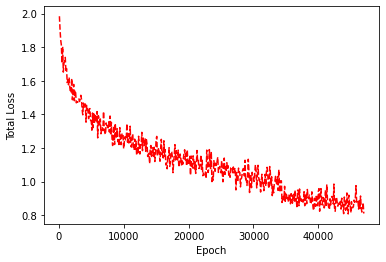

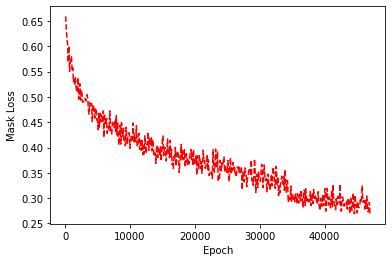

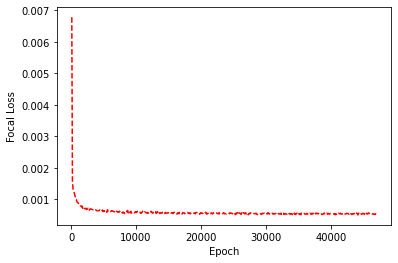

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Iters, Total_loss, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.show()
plt.plot(Iters, Mask_loss, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Mask Loss')
plt.show()
plt.plot(Iters, Focal_loss, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Focal Loss')
plt.show()

In [ ]:
solo_head = solo_head.to(device)
resnet50_fpn = Resnet50Backbone(device=device)
optimizer = torch.optim.SGD(solo_head.parameters(),lr=0.01/8,momentum=0.9,weight_decay=0.0001)
epochsdone = 0
path = ''
num_epochs = 36
resume=False
if resume:
  path = '/content/gdrive/My Drive/CIS680_2020/SOLO_RM/Result'+str(resume_epoch)
  checkpoint = torch.load(path)
  solo_head.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epochsdone = checkpoint['epoch']

Mask_loss = []
Focal_loss = []
Total_loss = []
Iters = []
num_iters = 0
tot_cumulative_loss = 0
mask_cumulative_loss = 0
focal_cumulative_loss = 0
for epochs in tqdm.tqdm(range(num_epochs-epochsdone)):
  start = time.time()
  solo_head.train()
  if epochs+epochsdone == 26:
    optimizer = torch.optim.SGD(solo_head.parameters(),lr=0.01/80,momentum=0.9,weight_decay=0.0001)

  if epochs+epochsdone == 33:
    optimizer = torch.optim.SGD(solo_head.parameters(),lr=0.01/800,momentum=0.9,weight_decay=0.0001)

  for i, data in enumerate(train_loader,0):
    num_iters += 1
    optimizer.zero_grad()
    img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]
    img = img.float()
    img=img.to(device)
    with torch.no_grad():
      backout = resnet50_fpn(img)
      fpn_feat_list = list(backout.values())
    del img
    ## passing through the network
    cate_pred_list,ins_pred_list = solo_head.forward(fpn_feat_list)
    del fpn_feat_list
    torch.cuda.empty_cache()
    ##building Target


    ins_gts_list, ins_ind_gts_list, cate_gts_list = solo_head.target(ins_pred_list,bbox_list,label_list,mask_list)
    del bbox_list,label_list,mask_list
    focal_loss,mask_loss,total_loss = solo_head.loss(cate_pred_list,ins_pred_list,ins_gts_list,ins_ind_gts_list,cate_gts_list)
    total_loss.backward()
    optimizer.step()
    if num_iters%100 != 0:
      tot_cumulative_loss += total_loss.cpu().item()
      mask_cumulative_loss += mask_loss.cpu().item()
      focal_cumulative_loss += focal_loss.cpu().item()
    else:
      Total_loss.append(tot_cumulative_loss/100)
      Mask_loss.append(mask_cumulative_loss/100)
      Focal_loss.append(focal_cumulative_loss/100)
      tot_cumulative_loss = 0
      mask_cumulative_loss = 0
      focal_cumulative_loss = 0
      Iters.append(num_iters)
      print("Epoch Number: {} | Iteration Number: {} | Focal Loss: {} | Mask Loss: {} | Total Loss: {}".format(epochs+epochsdone+1,num_iters,focal_loss.cpu().item(),(mask_loss*3).cpu().item(),total_loss.cpu().item()))
    # Mask_loss.append(mask_loss)
    # Total_loss.append(total_loss)
    # Focal_loss.append(focal_loss)
    # print('Epoch:{} | Focal Loss:{} | Mask Loss:{} | Total Loss:{}'.format(epochs+epochsdone+1,focal_loss.cpu().item(),mask_loss.cpu().item(),total_loss.cpu().item()))
  print('time taken in epoch {}:{}'.format(epochs+epochsdone+1,time.time()-start))
  ##saving model
  path = '/content/gdrive/My Drive/CIS680_2020/SOLO_RM/Result'+str(epochs+epochsdone+1)
  torch.save({\
              'epoch': epochs+1,\
              'model_state_dict': solo_head.state_dict(),\
              'optimizer_state_dict':optimizer.state_dict()\
              },path)



  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch Number: 1 | Iteration Number: 100 | Focal Loss: 0.0018742075189948082 | Mask Loss: 1.552658200263977 | Total Loss: 1.5545324087142944
Epoch Number: 1 | Iteration Number: 200 | Focal Loss: 0.001006061676889658 | Mask Loss: 2.2505416870117188 | Total Loss: 2.2515478134155273
Epoch Number: 1 | Iteration Number: 300 | Focal Loss: 0.001714092679321766 | Mask Loss: 1.6065205335617065 | Total Loss: 1.6082346439361572
Epoch Number: 1 | Iteration Number: 400 | Focal Loss: 0.0006730736349709332 | Mask Loss: 2.416978597640991 | Total Loss: 2.417651653289795
Epoch Number: 1 | Iteration Number: 500 | Focal Loss: 0.0011294613359495997 | Mask Loss: 1.4271061420440674 | Total Loss: 1.428235650062561
Epoch Number: 1 | Iteration Number: 600 | Focal Loss: 0.0007011469569988549 | Mask Loss: 2.590786933898926 | Total Loss: 2.5914881229400635
Epoch Number: 1 | Iteration Number: 700 | Focal Loss: 0.0005306447856128216 | Mask Loss: 2.1843576431274414 | Total Loss: 2.1848883628845215
Epoch Number: 1 | It

  3%|▎         | 1/36 [05:14<3:03:13, 314.10s/it]

time taken in epoch 1:314.0095992088318
Epoch Number: 2 | Iteration Number: 1400 | Focal Loss: 0.0008210517698898911 | Mask Loss: 1.3285704851150513 | Total Loss: 1.3293914794921875
Epoch Number: 2 | Iteration Number: 1500 | Focal Loss: 0.0006109167006798089 | Mask Loss: 0.9880867004394531 | Total Loss: 0.9886975884437561
Epoch Number: 2 | Iteration Number: 1600 | Focal Loss: 0.0007635928341187537 | Mask Loss: 1.5101616382598877 | Total Loss: 1.5109251737594604
Epoch Number: 2 | Iteration Number: 1700 | Focal Loss: 0.00043206530972383916 | Mask Loss: 1.7314884662628174 | Total Loss: 1.7319204807281494
Epoch Number: 2 | Iteration Number: 1800 | Focal Loss: 0.0008047071751207113 | Mask Loss: 1.23757004737854 | Total Loss: 1.2383747100830078
Epoch Number: 2 | Iteration Number: 1900 | Focal Loss: 0.0007497456972487271 | Mask Loss: 2.1149377822875977 | Total Loss: 2.115687608718872
Epoch Number: 2 | Iteration Number: 2000 | Focal Loss: 0.0006653419695794582 | Mask Loss: 0.7413042187690735 |

  6%|▌         | 2/36 [10:27<2:57:49, 313.81s/it]

time taken in epoch 2:313.05935287475586
Epoch Number: 3 | Iteration Number: 2700 | Focal Loss: 0.0006098366575315595 | Mask Loss: 1.0789072513580322 | Total Loss: 1.079517126083374
Epoch Number: 3 | Iteration Number: 2800 | Focal Loss: 0.000814532395452261 | Mask Loss: 1.1372164487838745 | Total Loss: 1.138031005859375
Epoch Number: 3 | Iteration Number: 2900 | Focal Loss: 0.0005393236060626805 | Mask Loss: 2.0529322624206543 | Total Loss: 2.053471565246582
Epoch Number: 3 | Iteration Number: 3000 | Focal Loss: 0.0005664191558025777 | Mask Loss: 1.2124598026275635 | Total Loss: 1.2130261659622192
Epoch Number: 3 | Iteration Number: 3100 | Focal Loss: 0.000592611322645098 | Mask Loss: 1.1589399576187134 | Total Loss: 1.1595325469970703
Epoch Number: 3 | Iteration Number: 3200 | Focal Loss: 0.000706391641870141 | Mask Loss: 1.1466518640518188 | Total Loss: 1.1473582983016968
Epoch Number: 3 | Iteration Number: 3300 | Focal Loss: 0.0007314466056413949 | Mask Loss: 1.0515334606170654 | To

  8%|▊         | 3/36 [15:40<2:52:29, 313.62s/it]

time taken in epoch 3:313.066606760025
Epoch Number: 4 | Iteration Number: 4000 | Focal Loss: 0.0005004550330340862 | Mask Loss: 1.095905065536499 | Total Loss: 1.0964055061340332
Epoch Number: 4 | Iteration Number: 4100 | Focal Loss: 0.0006814512307755649 | Mask Loss: 1.3708804845809937 | Total Loss: 1.371561884880066
Epoch Number: 4 | Iteration Number: 4200 | Focal Loss: 0.00043534213909879327 | Mask Loss: 1.490463137626648 | Total Loss: 1.4908984899520874
Epoch Number: 4 | Iteration Number: 4300 | Focal Loss: 0.000604175787884742 | Mask Loss: 2.4804763793945312 | Total Loss: 2.4810805320739746
Epoch Number: 4 | Iteration Number: 4400 | Focal Loss: 0.0007934992318041623 | Mask Loss: 0.7873464822769165 | Total Loss: 0.7881399989128113
Epoch Number: 4 | Iteration Number: 4500 | Focal Loss: 0.00053006736561656 | Mask Loss: 1.5034363269805908 | Total Loss: 1.5039664506912231
Epoch Number: 4 | Iteration Number: 4600 | Focal Loss: 0.0008073432254604995 | Mask Loss: 1.8691688776016235 | Tot

 11%|█         | 4/36 [20:53<2:47:09, 313.43s/it]

time taken in epoch 4:312.9134440422058
Epoch Number: 5 | Iteration Number: 5300 | Focal Loss: 0.0009340714896097779 | Mask Loss: 1.3373570442199707 | Total Loss: 1.3382911682128906
Epoch Number: 5 | Iteration Number: 5400 | Focal Loss: 0.0005929534090682864 | Mask Loss: 1.5930321216583252 | Total Loss: 1.5936250686645508
Epoch Number: 5 | Iteration Number: 5500 | Focal Loss: 0.0008417421486228704 | Mask Loss: 0.941841721534729 | Total Loss: 0.9426834583282471
Epoch Number: 5 | Iteration Number: 5600 | Focal Loss: 0.001194981043227017 | Mask Loss: 1.745518684387207 | Total Loss: 1.746713638305664
Epoch Number: 5 | Iteration Number: 5700 | Focal Loss: 0.0005642067408189178 | Mask Loss: 1.246255874633789 | Total Loss: 1.246820092201233
Epoch Number: 5 | Iteration Number: 5800 | Focal Loss: 0.00044209742918610573 | Mask Loss: 0.7499336004257202 | Total Loss: 0.7503756880760193
Epoch Number: 5 | Iteration Number: 5900 | Focal Loss: 0.0004171055043116212 | Mask Loss: 1.1491732597351074 | To

 14%|█▍        | 5/36 [26:08<2:42:16, 314.07s/it]

time taken in epoch 5:315.4633905887604
Epoch Number: 6 | Iteration Number: 6600 | Focal Loss: 0.0006485478952527046 | Mask Loss: 0.8879489898681641 | Total Loss: 0.8885975480079651
Epoch Number: 6 | Iteration Number: 6700 | Focal Loss: 0.0006052895914763212 | Mask Loss: 1.8389036655426025 | Total Loss: 1.8395090103149414
Epoch Number: 6 | Iteration Number: 6800 | Focal Loss: 0.0005365543183870614 | Mask Loss: 1.6142216920852661 | Total Loss: 1.6147582530975342
Epoch Number: 6 | Iteration Number: 6900 | Focal Loss: 0.001028978731483221 | Mask Loss: 1.567833662033081 | Total Loss: 1.5688626766204834
Epoch Number: 6 | Iteration Number: 7000 | Focal Loss: 0.0007628099992871284 | Mask Loss: 0.7680766582489014 | Total Loss: 0.7688394784927368
Epoch Number: 6 | Iteration Number: 7100 | Focal Loss: 0.0003478030557744205 | Mask Loss: 1.001760482788086 | Total Loss: 1.0021083354949951
Epoch Number: 6 | Iteration Number: 7200 | Focal Loss: 0.0007896187016740441 | Mask Loss: 1.041504979133606 | T

 17%|█▋        | 6/36 [31:23<2:37:03, 314.13s/it]

time taken in epoch 6:314.1919274330139
Epoch Number: 7 | Iteration Number: 7900 | Focal Loss: 0.0005350692663341761 | Mask Loss: 0.9748737215995789 | Total Loss: 0.9754087924957275
Epoch Number: 7 | Iteration Number: 8000 | Focal Loss: 0.0009916899725794792 | Mask Loss: 2.452615976333618 | Total Loss: 2.4536075592041016
Epoch Number: 7 | Iteration Number: 8100 | Focal Loss: 0.0004362948820926249 | Mask Loss: 0.75288987159729 | Total Loss: 0.7533261775970459
Epoch Number: 7 | Iteration Number: 8200 | Focal Loss: 0.0005310545675456524 | Mask Loss: 1.4114412069320679 | Total Loss: 1.4119722843170166
Epoch Number: 7 | Iteration Number: 8300 | Focal Loss: 0.0006563941715285182 | Mask Loss: 1.5878773927688599 | Total Loss: 1.5885337591171265
Epoch Number: 7 | Iteration Number: 8400 | Focal Loss: 0.000520368805155158 | Mask Loss: 1.1200695037841797 | Total Loss: 1.1205898523330688
Epoch Number: 7 | Iteration Number: 8500 | Focal Loss: 0.0004382253682706505 | Mask Loss: 1.6841819286346436 | T

 19%|█▉        | 7/36 [36:37<2:31:47, 314.06s/it]

time taken in epoch 7:313.8037271499634
Epoch Number: 8 | Iteration Number: 9200 | Focal Loss: 0.0006788645405322313 | Mask Loss: 1.3522534370422363 | Total Loss: 1.352932333946228
Epoch Number: 8 | Iteration Number: 9300 | Focal Loss: 0.0005401347298175097 | Mask Loss: 0.9139463901519775 | Total Loss: 0.9144865274429321
Epoch Number: 8 | Iteration Number: 9400 | Focal Loss: 0.00043763930443674326 | Mask Loss: 2.026456356048584 | Total Loss: 2.0268940925598145
Epoch Number: 8 | Iteration Number: 9500 | Focal Loss: 0.0005771679570898414 | Mask Loss: 1.3364897966384888 | Total Loss: 1.3370670080184937
Epoch Number: 8 | Iteration Number: 9600 | Focal Loss: 0.0006780911353416741 | Mask Loss: 0.9661222100257874 | Total Loss: 0.9668002724647522
Epoch Number: 8 | Iteration Number: 9700 | Focal Loss: 0.0005509686889126897 | Mask Loss: 0.9020593166351318 | Total Loss: 0.9026103019714355
Epoch Number: 8 | Iteration Number: 9800 | Focal Loss: 0.0006662844680249691 | Mask Loss: 1.1216961145401 | T

 22%|██▏       | 8/36 [41:50<2:26:30, 313.96s/it]

time taken in epoch 8:313.6110153198242
Epoch Number: 9 | Iteration Number: 10500 | Focal Loss: 0.00048689593677408993 | Mask Loss: 1.5326437950134277 | Total Loss: 1.5331306457519531
Epoch Number: 9 | Iteration Number: 10600 | Focal Loss: 0.0006362487329170108 | Mask Loss: 0.926680862903595 | Total Loss: 0.9273170828819275
Epoch Number: 9 | Iteration Number: 10700 | Focal Loss: 0.0007222718559205532 | Mask Loss: 0.7095839977264404 | Total Loss: 0.7103062868118286
Epoch Number: 9 | Iteration Number: 10800 | Focal Loss: 0.0008887660223990679 | Mask Loss: 1.2433717250823975 | Total Loss: 1.244260549545288
Epoch Number: 9 | Iteration Number: 10900 | Focal Loss: 0.0008078512037172914 | Mask Loss: 1.4061710834503174 | Total Loss: 1.406978964805603
Epoch Number: 9 | Iteration Number: 11000 | Focal Loss: 0.0004313295939937234 | Mask Loss: 0.6174861192703247 | Total Loss: 0.6179174780845642
Epoch Number: 9 | Iteration Number: 11100 | Focal Loss: 0.0005647496436722577 | Mask Loss: 1.14855289459

 25%|██▌       | 9/36 [47:04<2:21:11, 313.76s/it]

time taken in epoch 9:313.20863676071167
Epoch Number: 10 | Iteration Number: 11800 | Focal Loss: 0.000669483095407486 | Mask Loss: 1.5873939990997314 | Total Loss: 1.5880634784698486
Epoch Number: 10 | Iteration Number: 11900 | Focal Loss: 0.0006312302430160344 | Mask Loss: 1.9633212089538574 | Total Loss: 1.9639524221420288
Epoch Number: 10 | Iteration Number: 12000 | Focal Loss: 0.0007026813109405339 | Mask Loss: 1.7537341117858887 | Total Loss: 1.7544368505477905
Epoch Number: 10 | Iteration Number: 12100 | Focal Loss: 0.0008960491977632046 | Mask Loss: 1.3845219612121582 | Total Loss: 1.3854180574417114
Epoch Number: 10 | Iteration Number: 12200 | Focal Loss: 0.0006556417793035507 | Mask Loss: 2.493429183959961 | Total Loss: 2.4940848350524902
Epoch Number: 10 | Iteration Number: 12300 | Focal Loss: 0.0010276467073708773 | Mask Loss: 1.0002622604370117 | Total Loss: 1.001289963722229
Epoch Number: 10 | Iteration Number: 12400 | Focal Loss: 0.0006294808117672801 | Mask Loss: 1.1188

 28%|██▊       | 10/36 [52:18<2:16:06, 314.08s/it]

time taken in epoch 10:314.7450726032257
Epoch Number: 11 | Iteration Number: 13100 | Focal Loss: 0.00043626787373796105 | Mask Loss: 1.236955165863037 | Total Loss: 1.237391471862793
Epoch Number: 11 | Iteration Number: 13200 | Focal Loss: 0.00045628295629285276 | Mask Loss: 1.5725836753845215 | Total Loss: 1.5730400085449219
Epoch Number: 11 | Iteration Number: 13300 | Focal Loss: 0.00043755286606028676 | Mask Loss: 2.2032833099365234 | Total Loss: 2.203720808029175
Epoch Number: 11 | Iteration Number: 13400 | Focal Loss: 0.0004329318762756884 | Mask Loss: 1.1818548440933228 | Total Loss: 1.1822878122329712
Epoch Number: 11 | Iteration Number: 13500 | Focal Loss: 0.0006979189347475767 | Mask Loss: 0.9802460074424744 | Total Loss: 0.9809439182281494
Epoch Number: 11 | Iteration Number: 13600 | Focal Loss: 0.0004981036181561649 | Mask Loss: 1.6663910150527954 | Total Loss: 1.6668890714645386
Epoch Number: 11 | Iteration Number: 13700 | Focal Loss: 0.0009750723256729543 | Mask Loss: 0.9

 31%|███       | 11/36 [57:34<2:10:59, 314.38s/it]

time taken in epoch 11:314.98555040359497
Epoch Number: 12 | Iteration Number: 14400 | Focal Loss: 0.00042076033423654735 | Mask Loss: 1.260679841041565 | Total Loss: 1.2611006498336792
Epoch Number: 12 | Iteration Number: 14500 | Focal Loss: 0.0004444551304914057 | Mask Loss: 1.6361138820648193 | Total Loss: 1.6365582942962646
Epoch Number: 12 | Iteration Number: 14600 | Focal Loss: 0.0007328593637794256 | Mask Loss: 2.158576250076294 | Total Loss: 2.159309148788452
Epoch Number: 12 | Iteration Number: 14700 | Focal Loss: 0.0004332006792537868 | Mask Loss: 0.7882362604141235 | Total Loss: 0.7886694669723511
Epoch Number: 12 | Iteration Number: 14800 | Focal Loss: 0.0005012215115129948 | Mask Loss: 1.053044319152832 | Total Loss: 1.053545594215393
Epoch Number: 12 | Iteration Number: 14900 | Focal Loss: 0.0006342067499645054 | Mask Loss: 0.8367106914520264 | Total Loss: 0.8373448848724365
Epoch Number: 12 | Iteration Number: 15000 | Focal Loss: 0.0005785573739558458 | Mask Loss: 1.4541

 33%|███▎      | 12/36 [1:02:48<2:05:43, 314.33s/it]

time taken in epoch 12:314.11519050598145
Epoch Number: 13 | Iteration Number: 15700 | Focal Loss: 0.00045908376341685653 | Mask Loss: 1.0671732425689697 | Total Loss: 1.0676323175430298
Epoch Number: 13 | Iteration Number: 15800 | Focal Loss: 0.0006418224656954408 | Mask Loss: 0.5613264441490173 | Total Loss: 0.5619682669639587
Epoch Number: 13 | Iteration Number: 15900 | Focal Loss: 0.0006392481154762208 | Mask Loss: 1.0943429470062256 | Total Loss: 1.0949821472167969
Epoch Number: 13 | Iteration Number: 16000 | Focal Loss: 0.00051321234786883 | Mask Loss: 0.941730260848999 | Total Loss: 0.9422434568405151
Epoch Number: 13 | Iteration Number: 16100 | Focal Loss: 0.0005915634101256728 | Mask Loss: 0.8535963892936707 | Total Loss: 0.8541879653930664
Epoch Number: 13 | Iteration Number: 16200 | Focal Loss: 0.0003968751698266715 | Mask Loss: 1.755702257156372 | Total Loss: 1.7560991048812866
Epoch Number: 13 | Iteration Number: 16300 | Focal Loss: 0.000956492149271071 | Mask Loss: 0.9539

 36%|███▌      | 13/36 [1:08:01<2:00:23, 314.08s/it]

time taken in epoch 13:313.4273021221161
Epoch Number: 14 | Iteration Number: 17000 | Focal Loss: 0.0004972206661477685 | Mask Loss: 1.1017082929611206 | Total Loss: 1.102205514907837
Epoch Number: 14 | Iteration Number: 17100 | Focal Loss: 0.00035672966623678803 | Mask Loss: 1.842164397239685 | Total Loss: 1.842521071434021
Epoch Number: 14 | Iteration Number: 17200 | Focal Loss: 0.0006656681653112173 | Mask Loss: 0.8392728567123413 | Total Loss: 0.8399385213851929
Epoch Number: 14 | Iteration Number: 17300 | Focal Loss: 0.0008765172678977251 | Mask Loss: 1.4109306335449219 | Total Loss: 1.4118071794509888
Epoch Number: 14 | Iteration Number: 17400 | Focal Loss: 0.0003433993842918426 | Mask Loss: 0.8802182674407959 | Total Loss: 0.8805616497993469
Epoch Number: 14 | Iteration Number: 17500 | Focal Loss: 0.0007902942015789449 | Mask Loss: 1.007992148399353 | Total Loss: 1.0087823867797852
Epoch Number: 14 | Iteration Number: 17600 | Focal Loss: 0.0003661268565338105 | Mask Loss: 0.9775

 39%|███▉      | 14/36 [1:13:15<1:55:09, 314.07s/it]

time taken in epoch 14:313.94732904434204
Epoch Number: 15 | Iteration Number: 18300 | Focal Loss: 0.0004742987803183496 | Mask Loss: 0.7024781703948975 | Total Loss: 0.7029524445533752
Epoch Number: 15 | Iteration Number: 18400 | Focal Loss: 0.0004331535892561078 | Mask Loss: 1.1811705827713013 | Total Loss: 1.1816037893295288
Epoch Number: 15 | Iteration Number: 18500 | Focal Loss: 0.0005648998776450753 | Mask Loss: 1.8574233055114746 | Total Loss: 1.8579882383346558
Epoch Number: 15 | Iteration Number: 18600 | Focal Loss: 0.000789395475294441 | Mask Loss: 0.7375204563140869 | Total Loss: 0.7383098602294922
Epoch Number: 15 | Iteration Number: 18700 | Focal Loss: 0.00037997891195118427 | Mask Loss: 1.1283291578292847 | Total Loss: 1.128709077835083
Epoch Number: 15 | Iteration Number: 18800 | Focal Loss: 0.0007311651716008782 | Mask Loss: 1.708413004875183 | Total Loss: 1.709144115447998
Epoch Number: 15 | Iteration Number: 18900 | Focal Loss: 0.0005034400383010507 | Mask Loss: 1.066

 42%|████▏     | 15/36 [1:18:29<1:49:51, 313.89s/it]

time taken in epoch 15:313.3726098537445
Epoch Number: 16 | Iteration Number: 19600 | Focal Loss: 0.0003734059282578528 | Mask Loss: 1.9839413166046143 | Total Loss: 1.9843146800994873
Epoch Number: 16 | Iteration Number: 19700 | Focal Loss: 0.00046099661267362535 | Mask Loss: 1.0422816276550293 | Total Loss: 1.0427426099777222
Epoch Number: 16 | Iteration Number: 19800 | Focal Loss: 0.0005515091470442712 | Mask Loss: 2.7563891410827637 | Total Loss: 2.7569406032562256
Epoch Number: 16 | Iteration Number: 19900 | Focal Loss: 0.0007855412550270557 | Mask Loss: 1.0585211515426636 | Total Loss: 1.0593067407608032
Epoch Number: 16 | Iteration Number: 20000 | Focal Loss: 0.0008072817581705749 | Mask Loss: 0.6726903915405273 | Total Loss: 0.6734976768493652
Epoch Number: 16 | Iteration Number: 20100 | Focal Loss: 0.00033846349106170237 | Mask Loss: 0.6147181987762451 | Total Loss: 0.6150566339492798
Epoch Number: 16 | Iteration Number: 20200 | Focal Loss: 0.0008890864555723965 | Mask Loss: 1

 44%|████▍     | 16/36 [1:23:47<1:45:01, 315.06s/it]

time taken in epoch 16:317.7204432487488
Epoch Number: 17 | Iteration Number: 20900 | Focal Loss: 0.0004671978240367025 | Mask Loss: 1.675439715385437 | Total Loss: 1.6759068965911865
Epoch Number: 17 | Iteration Number: 21000 | Focal Loss: 0.00042639754246920347 | Mask Loss: 0.8556226491928101 | Total Loss: 0.8560490608215332
Epoch Number: 17 | Iteration Number: 21100 | Focal Loss: 0.0008681968320161104 | Mask Loss: 1.1829813718795776 | Total Loss: 1.183849573135376
Epoch Number: 17 | Iteration Number: 21200 | Focal Loss: 0.0003477860300336033 | Mask Loss: 1.3456779718399048 | Total Loss: 1.3460257053375244
Epoch Number: 17 | Iteration Number: 21300 | Focal Loss: 0.0007075283792801201 | Mask Loss: 1.0758718252182007 | Total Loss: 1.0765793323516846
Epoch Number: 17 | Iteration Number: 21400 | Focal Loss: 0.0004874994920101017 | Mask Loss: 1.0436972379684448 | Total Loss: 1.044184684753418
Epoch Number: 17 | Iteration Number: 21500 | Focal Loss: 0.0004640748957172036 | Mask Loss: 0.845

 47%|████▋     | 17/36 [1:29:06<1:40:09, 316.31s/it]

time taken in epoch 17:319.1418676376343
Epoch Number: 18 | Iteration Number: 22300 | Focal Loss: 0.0009049097425304353 | Mask Loss: 2.0375096797943115 | Total Loss: 2.038414478302002
Epoch Number: 18 | Iteration Number: 22400 | Focal Loss: 0.0007651526830159128 | Mask Loss: 1.7470569610595703 | Total Loss: 1.7478221654891968
Epoch Number: 18 | Iteration Number: 22500 | Focal Loss: 0.0006926223868504167 | Mask Loss: 1.9985461235046387 | Total Loss: 1.9992387294769287
Epoch Number: 18 | Iteration Number: 22600 | Focal Loss: 0.000502237759064883 | Mask Loss: 0.7978232502937317 | Total Loss: 0.7983254790306091
Epoch Number: 18 | Iteration Number: 22700 | Focal Loss: 0.0005412738537415862 | Mask Loss: 1.5218265056610107 | Total Loss: 1.5223678350448608
Epoch Number: 18 | Iteration Number: 22800 | Focal Loss: 0.0005251087131910026 | Mask Loss: 1.5154770612716675 | Total Loss: 1.5160021781921387
Epoch Number: 18 | Iteration Number: 22900 | Focal Loss: 0.0007612992776557803 | Mask Loss: 0.687

 50%|█████     | 18/36 [1:34:25<1:35:09, 317.20s/it]

time taken in epoch 18:319.19415163993835
Epoch Number: 19 | Iteration Number: 23600 | Focal Loss: 0.0006913069519214332 | Mask Loss: 1.3804281949996948 | Total Loss: 1.3811194896697998
Epoch Number: 19 | Iteration Number: 23700 | Focal Loss: 0.00033749130670912564 | Mask Loss: 1.040290117263794 | Total Loss: 1.0406275987625122
Epoch Number: 19 | Iteration Number: 23800 | Focal Loss: 0.0006021744920872152 | Mask Loss: 0.8298686742782593 | Total Loss: 0.830470860004425
Epoch Number: 19 | Iteration Number: 23900 | Focal Loss: 0.00047728142817504704 | Mask Loss: 1.1694828271865845 | Total Loss: 1.1699601411819458
Epoch Number: 19 | Iteration Number: 24000 | Focal Loss: 0.00045137759298086166 | Mask Loss: 1.2489712238311768 | Total Loss: 1.249422550201416
Epoch Number: 19 | Iteration Number: 24100 | Focal Loss: 0.0004322119930293411 | Mask Loss: 0.513808012008667 | Total Loss: 0.5142402052879333
Epoch Number: 19 | Iteration Number: 24200 | Focal Loss: 0.0005143110756762326 | Mask Loss: 0.8

 53%|█████▎    | 19/36 [1:39:42<1:29:50, 317.09s/it]

time taken in epoch 19:316.70120096206665
Epoch Number: 20 | Iteration Number: 24900 | Focal Loss: 0.00046589510748162866 | Mask Loss: 0.6753754019737244 | Total Loss: 0.6758412718772888
Epoch Number: 20 | Iteration Number: 25000 | Focal Loss: 0.0005889289313927293 | Mask Loss: 0.8741183280944824 | Total Loss: 0.8747072815895081
Epoch Number: 20 | Iteration Number: 25100 | Focal Loss: 0.0006871283985674381 | Mask Loss: 0.9068993330001831 | Total Loss: 0.9075864553451538
Epoch Number: 20 | Iteration Number: 25200 | Focal Loss: 0.0004789302183780819 | Mask Loss: 0.4173893928527832 | Total Loss: 0.41786831617355347
Epoch Number: 20 | Iteration Number: 25300 | Focal Loss: 0.00038800950278528035 | Mask Loss: 1.1366913318634033 | Total Loss: 1.1370793581008911
Epoch Number: 20 | Iteration Number: 25400 | Focal Loss: 0.0005949795595370233 | Mask Loss: 1.032627820968628 | Total Loss: 1.0332227945327759
Epoch Number: 20 | Iteration Number: 25500 | Focal Loss: 0.0006216162582859397 | Mask Loss: 

 56%|█████▌    | 20/36 [1:44:57<1:24:22, 316.41s/it]

time taken in epoch 20:314.7480547428131
Epoch Number: 21 | Iteration Number: 26200 | Focal Loss: 0.0005906145670451224 | Mask Loss: 1.4395549297332764 | Total Loss: 1.440145492553711
Epoch Number: 21 | Iteration Number: 26300 | Focal Loss: 0.0004811823309864849 | Mask Loss: 1.242457389831543 | Total Loss: 1.24293851852417
Epoch Number: 21 | Iteration Number: 26400 | Focal Loss: 0.0006444394821301103 | Mask Loss: 1.4147893190383911 | Total Loss: 1.4154337644577026
Epoch Number: 21 | Iteration Number: 26500 | Focal Loss: 0.0006760703981854022 | Mask Loss: 1.3858742713928223 | Total Loss: 1.3865503072738647
Epoch Number: 21 | Iteration Number: 26600 | Focal Loss: 0.0004896146710962057 | Mask Loss: 0.7479580640792847 | Total Loss: 0.7484476566314697
Epoch Number: 21 | Iteration Number: 26700 | Focal Loss: 0.00047074141912162304 | Mask Loss: 0.8349618911743164 | Total Loss: 0.8354326486587524
Epoch Number: 21 | Iteration Number: 26800 | Focal Loss: 0.0005174532998353243 | Mask Loss: 1.6791

 58%|█████▊    | 21/36 [1:50:09<1:18:45, 315.05s/it]

time taken in epoch 21:311.7978627681732
Epoch Number: 22 | Iteration Number: 27500 | Focal Loss: 0.0005678938468918204 | Mask Loss: 1.6856670379638672 | Total Loss: 1.686234951019287
Epoch Number: 22 | Iteration Number: 27600 | Focal Loss: 0.0007353146793320775 | Mask Loss: 1.1012601852416992 | Total Loss: 1.1019954681396484
Epoch Number: 22 | Iteration Number: 27700 | Focal Loss: 0.0005748830735683441 | Mask Loss: 0.6292101740837097 | Total Loss: 0.6297850608825684
Epoch Number: 22 | Iteration Number: 27800 | Focal Loss: 0.0005269161774776876 | Mask Loss: 0.5011053681373596 | Total Loss: 0.5016322731971741
Epoch Number: 22 | Iteration Number: 27900 | Focal Loss: 0.0005556950345635414 | Mask Loss: 0.845616340637207 | Total Loss: 0.846172034740448
Epoch Number: 22 | Iteration Number: 28000 | Focal Loss: 0.00045043480349704623 | Mask Loss: 1.1580227613449097 | Total Loss: 1.158473253250122
Epoch Number: 22 | Iteration Number: 28100 | Focal Loss: 0.0005513224168680608 | Mask Loss: 0.8266

 61%|██████    | 22/36 [1:55:21<1:13:20, 314.33s/it]

time taken in epoch 22:312.55570578575134
Epoch Number: 23 | Iteration Number: 28800 | Focal Loss: 0.0005629516672343016 | Mask Loss: 1.1339092254638672 | Total Loss: 1.134472131729126
Epoch Number: 23 | Iteration Number: 28900 | Focal Loss: 0.000591000251006335 | Mask Loss: 1.2883763313293457 | Total Loss: 1.2889673709869385
Epoch Number: 23 | Iteration Number: 29000 | Focal Loss: 0.000817767926491797 | Mask Loss: 1.5746288299560547 | Total Loss: 1.575446605682373
Epoch Number: 23 | Iteration Number: 29100 | Focal Loss: 0.0005888118757866323 | Mask Loss: 1.6651277542114258 | Total Loss: 1.665716528892517
Epoch Number: 23 | Iteration Number: 29200 | Focal Loss: 0.0009719294612295926 | Mask Loss: 1.155042052268982 | Total Loss: 1.1560139656066895
Epoch Number: 23 | Iteration Number: 29300 | Focal Loss: 0.0004190777544863522 | Mask Loss: 1.596374273300171 | Total Loss: 1.596793293952942
Epoch Number: 23 | Iteration Number: 29400 | Focal Loss: 0.0003721558896359056 | Mask Loss: 0.76977813

 64%|██████▍   | 23/36 [2:00:36<1:08:07, 314.39s/it]

time taken in epoch 23:314.4219186306
Epoch Number: 24 | Iteration Number: 30100 | Focal Loss: 0.0006501196185126901 | Mask Loss: 0.7415807843208313 | Total Loss: 0.7422308921813965
Epoch Number: 24 | Iteration Number: 30200 | Focal Loss: 0.0004597888619173318 | Mask Loss: 1.1561864614486694 | Total Loss: 1.1566462516784668
Epoch Number: 24 | Iteration Number: 30300 | Focal Loss: 0.0006107495864853263 | Mask Loss: 1.316977620124817 | Total Loss: 1.3175883293151855
Epoch Number: 24 | Iteration Number: 30400 | Focal Loss: 0.0006609816337004304 | Mask Loss: 1.7954628467559814 | Total Loss: 1.7961238622665405
Epoch Number: 24 | Iteration Number: 30500 | Focal Loss: 0.000350830378010869 | Mask Loss: 0.43867743015289307 | Total Loss: 0.439028263092041
Epoch Number: 24 | Iteration Number: 30600 | Focal Loss: 0.0007955677574500442 | Mask Loss: 0.947510838508606 | Total Loss: 0.9483063817024231
Epoch Number: 24 | Iteration Number: 30700 | Focal Loss: 0.00031717834644950926 | Mask Loss: 1.595794

 67%|██████▋   | 24/36 [2:05:50<1:02:52, 314.37s/it]

time taken in epoch 24:314.23589849472046
Epoch Number: 25 | Iteration Number: 31400 | Focal Loss: 0.0004918298218399286 | Mask Loss: 0.8870757818222046 | Total Loss: 0.8875676393508911
Epoch Number: 25 | Iteration Number: 31500 | Focal Loss: 0.0005779203493148088 | Mask Loss: 0.8319584131240845 | Total Loss: 0.8325363397598267
Epoch Number: 25 | Iteration Number: 31600 | Focal Loss: 0.0005891218315809965 | Mask Loss: 1.3744186162948608 | Total Loss: 1.3750077486038208
Epoch Number: 25 | Iteration Number: 31700 | Focal Loss: 0.00034358917037025094 | Mask Loss: 1.1185050010681152 | Total Loss: 1.1188485622406006
Epoch Number: 25 | Iteration Number: 31800 | Focal Loss: 0.0005598379648290575 | Mask Loss: 0.8643490076065063 | Total Loss: 0.8649088740348816
Epoch Number: 25 | Iteration Number: 31900 | Focal Loss: 0.00032472499879077077 | Mask Loss: 0.28678783774375916 | Total Loss: 0.2871125638484955
Epoch Number: 25 | Iteration Number: 32000 | Focal Loss: 0.0006207972764968872 | Mask Loss:

 69%|██████▉   | 25/36 [2:11:04<57:38, 314.37s/it]  

time taken in epoch 25:314.26117610931396
Epoch Number: 26 | Iteration Number: 32700 | Focal Loss: 0.000478465692140162 | Mask Loss: 0.7465101480484009 | Total Loss: 0.7469885945320129
Epoch Number: 26 | Iteration Number: 32800 | Focal Loss: 0.0007367618381977081 | Mask Loss: 1.5387336015701294 | Total Loss: 1.5394703149795532
Epoch Number: 26 | Iteration Number: 32900 | Focal Loss: 0.0003525397623889148 | Mask Loss: 0.479478657245636 | Total Loss: 0.47983118891716003
Epoch Number: 26 | Iteration Number: 33000 | Focal Loss: 0.00040772827924229205 | Mask Loss: 1.1099364757537842 | Total Loss: 1.1103441715240479
Epoch Number: 26 | Iteration Number: 33100 | Focal Loss: 0.0004539760120678693 | Mask Loss: 0.767767071723938 | Total Loss: 0.7682210206985474
Epoch Number: 26 | Iteration Number: 33200 | Focal Loss: 0.0006885790498927236 | Mask Loss: 0.5820363759994507 | Total Loss: 0.582724928855896
Epoch Number: 26 | Iteration Number: 33300 | Focal Loss: 0.0003748325107153505 | Mask Loss: 1.70

 72%|███████▏  | 26/36 [2:16:20<52:28, 314.83s/it]

time taken in epoch 26:315.79531359672546
Epoch Number: 27 | Iteration Number: 34000 | Focal Loss: 0.0005987611366435885 | Mask Loss: 1.2363072633743286 | Total Loss: 1.2369060516357422
Epoch Number: 27 | Iteration Number: 34100 | Focal Loss: 0.0006420022691600025 | Mask Loss: 0.9907277822494507 | Total Loss: 0.9913697838783264
Epoch Number: 27 | Iteration Number: 34200 | Focal Loss: 0.0005197154823690653 | Mask Loss: 0.41477280855178833 | Total Loss: 0.41529253125190735
Epoch Number: 27 | Iteration Number: 34300 | Focal Loss: 0.00038488770951516926 | Mask Loss: 0.5892620086669922 | Total Loss: 0.5896468758583069
Epoch Number: 27 | Iteration Number: 34400 | Focal Loss: 0.0006349169416353106 | Mask Loss: 1.529200792312622 | Total Loss: 1.5298357009887695
Epoch Number: 27 | Iteration Number: 34500 | Focal Loss: 0.000762735609896481 | Mask Loss: 1.1822946071624756 | Total Loss: 1.1830573081970215
Epoch Number: 27 | Iteration Number: 34600 | Focal Loss: 0.000725672347471118 | Mask Loss: 1.

 75%|███████▌  | 27/36 [2:21:32<47:05, 313.96s/it]

time taken in epoch 27:311.8497655391693
Epoch Number: 28 | Iteration Number: 35300 | Focal Loss: 0.00041567726293578744 | Mask Loss: 1.0380172729492188 | Total Loss: 1.0384329557418823
Epoch Number: 28 | Iteration Number: 35400 | Focal Loss: 0.0006870893412269652 | Mask Loss: 1.1228547096252441 | Total Loss: 1.1235418319702148
Epoch Number: 28 | Iteration Number: 35500 | Focal Loss: 0.0008921534172259271 | Mask Loss: 1.1504020690917969 | Total Loss: 1.151294231414795
Epoch Number: 28 | Iteration Number: 35600 | Focal Loss: 0.0006434346432797611 | Mask Loss: 1.415323257446289 | Total Loss: 1.4159667491912842
Epoch Number: 28 | Iteration Number: 35700 | Focal Loss: 0.00040468107908964157 | Mask Loss: 0.7195906639099121 | Total Loss: 0.7199953198432922
Epoch Number: 28 | Iteration Number: 35800 | Focal Loss: 0.0004462280194275081 | Mask Loss: 1.3249924182891846 | Total Loss: 1.3254386186599731
Epoch Number: 28 | Iteration Number: 35900 | Focal Loss: 0.0004518947098404169 | Mask Loss: 0.7

 78%|███████▊  | 28/36 [2:26:45<41:49, 313.67s/it]

time taken in epoch 28:312.88877964019775
Epoch Number: 29 | Iteration Number: 36600 | Focal Loss: 0.000725722115021199 | Mask Loss: 1.056495189666748 | Total Loss: 1.0572209358215332
Epoch Number: 29 | Iteration Number: 36700 | Focal Loss: 0.0006204370292834938 | Mask Loss: 0.8959416747093201 | Total Loss: 0.8965620994567871
Epoch Number: 29 | Iteration Number: 36800 | Focal Loss: 0.0005175005062483251 | Mask Loss: 1.3379725217819214 | Total Loss: 1.3384900093078613
Epoch Number: 29 | Iteration Number: 36900 | Focal Loss: 0.0004509839927777648 | Mask Loss: 1.280185580253601 | Total Loss: 1.2806365489959717
Epoch Number: 29 | Iteration Number: 37000 | Focal Loss: 0.0005295851151458919 | Mask Loss: 1.3602784872055054 | Total Loss: 1.36080801486969
Epoch Number: 29 | Iteration Number: 37100 | Focal Loss: 0.0005705272196792066 | Mask Loss: 1.2117691040039062 | Total Loss: 1.2123396396636963
Epoch Number: 29 | Iteration Number: 37200 | Focal Loss: 0.000471152103273198 | Mask Loss: 0.448334

 81%|████████  | 29/36 [2:31:59<36:36, 313.83s/it]

time taken in epoch 29:314.08375573158264
Epoch Number: 30 | Iteration Number: 37900 | Focal Loss: 0.0005025470745749772 | Mask Loss: 0.6920282244682312 | Total Loss: 0.6925307512283325
Epoch Number: 30 | Iteration Number: 38000 | Focal Loss: 0.0007442373316735029 | Mask Loss: 1.9336097240447998 | Total Loss: 1.9343539476394653
Epoch Number: 30 | Iteration Number: 38100 | Focal Loss: 0.00048391043674200773 | Mask Loss: 0.99693763256073 | Total Loss: 0.9974215626716614
Epoch Number: 30 | Iteration Number: 38200 | Focal Loss: 0.0004952147137373686 | Mask Loss: 0.3576223850250244 | Total Loss: 0.35811761021614075
Epoch Number: 30 | Iteration Number: 38300 | Focal Loss: 0.00043384029413573444 | Mask Loss: 1.282772183418274 | Total Loss: 1.2832059860229492
Epoch Number: 30 | Iteration Number: 38400 | Focal Loss: 0.0005410105222836137 | Mask Loss: 1.2384021282196045 | Total Loss: 1.238943099975586
Epoch Number: 30 | Iteration Number: 38500 | Focal Loss: 0.00040068707312457263 | Mask Loss: 0.

 83%|████████▎ | 30/36 [2:37:12<31:19, 313.31s/it]

time taken in epoch 30:312.0308725833893
Epoch Number: 31 | Iteration Number: 39200 | Focal Loss: 0.0004887478426098824 | Mask Loss: 1.358537197113037 | Total Loss: 1.3590259552001953
Epoch Number: 31 | Iteration Number: 39300 | Focal Loss: 0.000769608945120126 | Mask Loss: 2.007432222366333 | Total Loss: 2.008201837539673
Epoch Number: 31 | Iteration Number: 39400 | Focal Loss: 0.00044779025483876467 | Mask Loss: 0.7306992411613464 | Total Loss: 0.731147050857544
Epoch Number: 31 | Iteration Number: 39500 | Focal Loss: 0.0003910251834895462 | Mask Loss: 0.6504791975021362 | Total Loss: 0.6508702039718628
Epoch Number: 31 | Iteration Number: 39600 | Focal Loss: 0.0003650479775387794 | Mask Loss: 0.3620226979255676 | Total Loss: 0.3623877465724945
Epoch Number: 31 | Iteration Number: 39700 | Focal Loss: 0.0005307560204528272 | Mask Loss: 0.9401348233222961 | Total Loss: 0.940665602684021
Epoch Number: 31 | Iteration Number: 39800 | Focal Loss: 0.0005192909156903625 | Mask Loss: 0.656390

 86%|████████▌ | 31/36 [2:42:24<26:05, 313.10s/it]

time taken in epoch 31:312.5033028125763
Epoch Number: 32 | Iteration Number: 40500 | Focal Loss: 0.0013413585256785154 | Mask Loss: 0.7877381443977356 | Total Loss: 0.789079487323761
Epoch Number: 32 | Iteration Number: 40600 | Focal Loss: 0.0005128071643412113 | Mask Loss: 2.2803688049316406 | Total Loss: 2.280881643295288
Epoch Number: 32 | Iteration Number: 40700 | Focal Loss: 0.0005184751935303211 | Mask Loss: 0.5191748142242432 | Total Loss: 0.5196933150291443
Epoch Number: 32 | Iteration Number: 40800 | Focal Loss: 0.000745466270018369 | Mask Loss: 0.9423456788063049 | Total Loss: 0.9430911540985107
Epoch Number: 32 | Iteration Number: 40900 | Focal Loss: 0.0004769724328070879 | Mask Loss: 1.2924931049346924 | Total Loss: 1.292970061302185
Epoch Number: 32 | Iteration Number: 41000 | Focal Loss: 0.0008636876591481268 | Mask Loss: 0.8611181974411011 | Total Loss: 0.8619818687438965
Epoch Number: 32 | Iteration Number: 41100 | Focal Loss: 0.0005897420924156904 | Mask Loss: 0.72007

 89%|████████▉ | 32/36 [2:47:36<20:51, 312.80s/it]

time taken in epoch 32:312.008234500885
Epoch Number: 33 | Iteration Number: 41800 | Focal Loss: 0.0008979664416983724 | Mask Loss: 1.5103223323822021 | Total Loss: 1.5112203359603882
Epoch Number: 33 | Iteration Number: 41900 | Focal Loss: 0.0006848783232271671 | Mask Loss: 1.260796070098877 | Total Loss: 1.2614809274673462
Epoch Number: 33 | Iteration Number: 42000 | Focal Loss: 0.0007140664383769035 | Mask Loss: 0.6216565370559692 | Total Loss: 0.6223706007003784
Epoch Number: 33 | Iteration Number: 42100 | Focal Loss: 0.00032712388201616704 | Mask Loss: 0.4664956033229828 | Total Loss: 0.46682271361351013
Epoch Number: 33 | Iteration Number: 42200 | Focal Loss: 0.000608435773756355 | Mask Loss: 1.1556541919708252 | Total Loss: 1.1562626361846924
Epoch Number: 33 | Iteration Number: 42300 | Focal Loss: 0.0005746515234932303 | Mask Loss: 2.170964002609253 | Total Loss: 2.1715385913848877
Epoch Number: 33 | Iteration Number: 42400 | Focal Loss: 0.0005809692665934563 | Mask Loss: 1.258

 92%|█████████▏| 33/36 [2:52:49<15:38, 312.91s/it]

time taken in epoch 33:313.07066559791565
Epoch Number: 34 | Iteration Number: 43100 | Focal Loss: 0.00048249150859192014 | Mask Loss: 1.002116322517395 | Total Loss: 1.002598762512207
Epoch Number: 34 | Iteration Number: 43200 | Focal Loss: 0.00042925719753839076 | Mask Loss: 1.0377871990203857 | Total Loss: 1.038216471672058
Epoch Number: 34 | Iteration Number: 43300 | Focal Loss: 0.0007117069908417761 | Mask Loss: 1.722215175628662 | Total Loss: 1.7229268550872803
Epoch Number: 34 | Iteration Number: 43400 | Focal Loss: 0.000379344099201262 | Mask Loss: 1.2404053211212158 | Total Loss: 1.2407846450805664
Epoch Number: 34 | Iteration Number: 43500 | Focal Loss: 0.0009604290826246142 | Mask Loss: 0.8452643156051636 | Total Loss: 0.8462247252464294
Epoch Number: 34 | Iteration Number: 43600 | Focal Loss: 0.0004630360926967114 | Mask Loss: 0.7682255506515503 | Total Loss: 0.7686885595321655
Epoch Number: 34 | Iteration Number: 43700 | Focal Loss: 0.0004442730569280684 | Mask Loss: 0.790

 94%|█████████▍| 34/36 [2:58:06<10:27, 313.87s/it]

time taken in epoch 34:316.0100769996643
Epoch Number: 35 | Iteration Number: 44500 | Focal Loss: 0.0007383572519756854 | Mask Loss: 0.8026055097579956 | Total Loss: 0.8033438920974731
Epoch Number: 35 | Iteration Number: 44600 | Focal Loss: 0.0006439388962462544 | Mask Loss: 1.1169970035552979 | Total Loss: 1.1176409721374512
Epoch Number: 35 | Iteration Number: 44700 | Focal Loss: 0.00038530302117578685 | Mask Loss: 0.40268513560295105 | Total Loss: 0.40307044982910156
Epoch Number: 35 | Iteration Number: 44800 | Focal Loss: 0.0005054005887359381 | Mask Loss: 0.4128668010234833 | Total Loss: 0.4133721888065338
Epoch Number: 35 | Iteration Number: 44900 | Focal Loss: 0.0007288148044608533 | Mask Loss: 1.8459856510162354 | Total Loss: 1.8467144966125488
Epoch Number: 35 | Iteration Number: 45000 | Focal Loss: 0.0007148198201321065 | Mask Loss: 0.7892782688140869 | Total Loss: 0.7899931073188782
Epoch Number: 35 | Iteration Number: 45100 | Focal Loss: 0.0004418588359840214 | Mask Loss: 

 97%|█████████▋| 35/36 [3:03:21<05:14, 314.38s/it]

time taken in epoch 35:315.4768702983856
Epoch Number: 36 | Iteration Number: 45800 | Focal Loss: 0.0006153958383947611 | Mask Loss: 0.6020145416259766 | Total Loss: 0.6026299595832825
Epoch Number: 36 | Iteration Number: 45900 | Focal Loss: 0.0005123025039210916 | Mask Loss: 0.7159909009933472 | Total Loss: 0.7165032029151917
Epoch Number: 36 | Iteration Number: 46000 | Focal Loss: 0.0004257804830558598 | Mask Loss: 1.3891892433166504 | Total Loss: 1.3896150588989258
Epoch Number: 36 | Iteration Number: 46100 | Focal Loss: 0.0005012593464925885 | Mask Loss: 0.46818071603775024 | Total Loss: 0.4686819612979889
Epoch Number: 36 | Iteration Number: 46200 | Focal Loss: 0.00034687487641349435 | Mask Loss: 0.5694364309310913 | Total Loss: 0.5697833299636841
Epoch Number: 36 | Iteration Number: 46300 | Focal Loss: 0.00024051027139648795 | Mask Loss: 0.9905468225479126 | Total Loss: 0.9907873272895813
Epoch Number: 36 | Iteration Number: 46400 | Focal Loss: 0.0004400017496664077 | Mask Loss: 

100%|██████████| 36/36 [3:08:36<00:00, 314.33s/it]

time taken in epoch 36:314.27671575546265


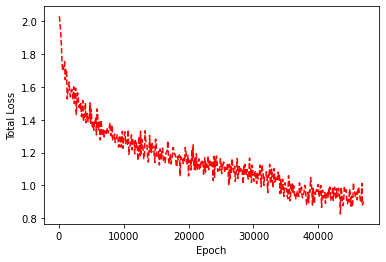

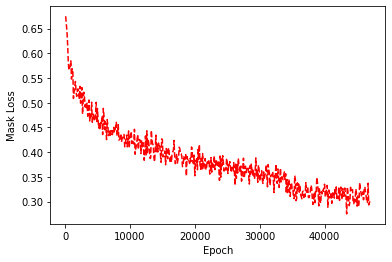

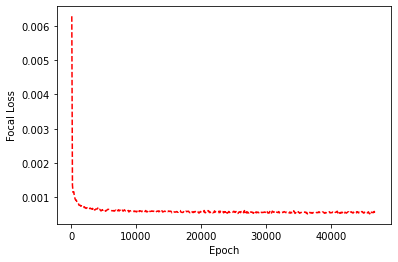

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Iters, Total_loss, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.show()
plt.plot(Iters, Mask_loss, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Mask Loss')
plt.show()
plt.plot(Iters, Focal_loss, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Focal Loss')
plt.show()

# Post-Processing

In [ ]:

def PostProcess(ins_pred_list, cate_pred_list,ori_size):
  a=[]
  NMS_sorted_scores_list=[]
  NMS_sorted_cate_label_list=[]
  NMS_sorted_ins_list=[]
  ## TODO: finish PostProcess
  for bz in range(len(cate_pred_list[0])):
    for i in range(len(cate_pred_list)):
      img_fpn=torch.zeros(cate_pred_list[i][bz].shape[0]**2,3)
      img_fpn=cate_pred_list[i][bz].reshape(cate_pred_list[i][bz].shape[0]**2,3)
      a.append(img_fpn)
    cate_pred_img=torch.cat((a[0],a[1],a[2],a[3],a[4]),0)
    ins_pred_img=torch.cat((ins_pred_list[0][bz],ins_pred_list[1][bz],ins_pred_list[2][bz],ins_pred_list[3][bz],ins_pred_list[4][bz]),0)
    c_thresh=0.1
    i_thresh=0.7   
    sorted_scores=[]
    sorted_cate_label_list=[]
    sorted_ins=[]
    cate_pred_img=cate_pred_img.cpu().numpy()
    ins_pred_img=ins_pred_img.cpu().numpy()
    for k in range(len(cate_pred_img)):
      if (np.max(cate_pred_img[k])>c_thresh):
        i_sum=0
        count=0
        for i in range(len(ins_pred_img[0])):
          for j in range(len(ins_pred_img[0][0])):
            if (ins_pred_img[k][i][j]>i_thresh):
              i_sum+=ins_pred_img[k][i][j]
              count+=1
        if count!=0:
          i_sum=i_sum/count
          sorted_scores.append(i_sum)
          sorted_cate_label_list.append(np.argmax(cate_pred_img[k]))
          sorted_ins.append(ins_pred_img[k])
    if len(sorted_scores)>0:
      sorted_scores, sorted_cate_label_list,sorted_ins = zip(*sorted(zip(sorted_scores, sorted_cate_label_list,sorted_ins),reverse=True))
    print(sorted_scores,sorted_cate_label_list,len(sorted_ins))
    
    #break
    if k > 5:
      return sorted_ins,sorted_scores,sorted_cate_label_list
      break
      
def MatrixNMS(sorted_ins, sorted_scores,sorted_cate_label_list, method='gauss', gauss_sigma=0.5):
        ## TODO: finish MatrixNMS
        ins=np.asarray(sorted_ins)
        for i in range(len(ins)):
          for j in range(len(ins[0])):
            for k in range(len(ins[0][0])):
              if (ins[i][j][k]>=0.5):
                ins[i][j][k]=1
              else:
                ins[i][j][k]=0   

        scores=np.asarray(sorted_scores)
        print(ins.shape)
        masks=ins.reshape(len(ins),len(ins[0])*len(ins[0][0]))
        intersection=np.matmul(masks, masks.T)
        print(type(masks))
        print(masks.shape)
        masks=torch.from_numpy(masks)
        areas=masks.sum(axis=1).expand(len(ins),len(ins))
        union=areas+areas.T-intersection
        ious=(intersection/union).triu(diagonal=1)
        ious_cmax,_=ious.max(0)
        ious_cmax=ious_cmax.expand(len(ins),len(ins)).T
        decay=np.zeros((len(ins),len(ins)))
        ious=ious.numpy()
        ious_cmax=ious_cmax.numpy()
        for i in range(len(ins)):
          for j in range(len(ins)):
            if method=='gauss':
              decay[i][j]=math.exp(-(ious[i][j]**2-ious_cmax[i][j]**2)/gauss_sigma)
            else:
              decay[i][j]=(1-ious[i][j])/(1-ious_cmax[i][j])

        decay=np.amin(decay, axis=0)
        scores=scores*decay
        if len(scores)>0:
          scores, ins,sorted_cate_label_list = zip(*sorted(zip(scores, ins,sorted_cate_label_list),reverse=True))
        print(scores[:5])
        scores=np.asarray(scores)
        ins=np.asarray(ins)
        sorted_cate_label_list=np.asarray(sorted_cate_label_list)
        return scores[:5],ins[:5],sorted_cate_label_list[:5]


In [ ]:
checkpoint = torch.load('/content/gdrive/My Drive/CIS680_Rectified/SOLO_RM/Result2_20')
solo_head.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [ ]:
while(1):
  mask_color_list = ["jet", "ocean", "Spectral"]
  seg_num_grids=[40, 36, 24, 16, 12]
  with torch.no_grad():
    solo_head.eval()
    for i, data in enumerate(test_loader,0):
      optimizer.zero_grad()
      img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]
      img = img.float()
      img=img.to(device)
      backout = resnet50_fpn(img)
      fpn_feat_list = list(backout.values())
      cate_pred_list,ins_pred_list = solo_head.forward(fpn_feat_list,eval=True) 
      break
  import math
  sorted_ins,sorted_scores,sorted_cate_label_list=PostProcess(ins_pred_list,cate_pred_list,[4,400])
  #ins_pred_list, cate_pred_list, ori_size = PostProcess(ins_pred_list, cate_pred_list,[800,1088])
  decay_scores,decay_masks,decay_labels=MatrixNMS(sorted_ins[:50],sorted_scores[:50],sorted_cate_label_list[:50], method='gauss', gauss_sigma=0.5)
  for i in range(5):
    mask=torch.from_numpy(decay_masks[i])
    label=decay_labels[i]
    mask=mask.unsqueeze(0)
    mask = mask.permute(0, 2, 1)
    mask = F.interpolate(mask, size=800)
    mask = mask.permute(0, 2, 1)
    mask = F.interpolate(mask, size=1066)
    mask=F.pad(mask,(11,11),value=0)
    plt.imshow(img[0].permute(1,2,0).data.long().cpu().numpy())
    mask_f=mask
    mask_f = np.reshape(mask_f,(800,1088,1))
    masked = np.ma.masked_where(mask_f == 0, mask_f)
    masked=np.squeeze(masked)
    plt.imshow(masked, cmap=mask_color_list[label], alpha=0.7)
    plt.show()
#sorted_scores,sorted_cate_label_list,sorted_ins=PostProcess(ins_pred_list,cate_pred_list,[4,400])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
solo_head = solo_head.to(device)
resnet50_fpn = Resnet50Backbone(device=device)
optimizer = torch.optim.SGD(solo_head.parameters(),lr=0.01/8,momentum=0.9,weight_decay=0.0001)

resume=True
if resume:
  path = '/content/gdrive/My Drive/CIS680_Rectified/SOLO_RM/Result'+str(36)
  checkpoint = torch.load(path)
  solo_head.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epochsdone = checkpoint['epoch']

In [ ]:
Mask_loss = []
Focal_loss = []
Total_loss = []
Iters = []
num_iters = 0
tot_cumulative_loss = 0
mask_cumulative_loss = 0
focal_cumulative_loss = 0
epochsdone = 0
num_epochs = 20
for epochs in tqdm.tqdm(range(num_epochs-epochsdone)):
  start = time.time()
  solo_head.train()
  if epochs+epochsdone == 26:
    optimizer = torch.optim.SGD(solo_head.parameters(),lr=0.01/80,momentum=0.9,weight_decay=0.0001)
  if epochs+epochsdone == 33:
    optimizer = torch.optim.SGD(solo_head.parameters(),lr=0.01/800,momentum=0.9,weight_decay=0.0001)
  for i, data in enumerate(train_loader,0):
    num_iters += 1
    optimizer.zero_grad()
    img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]
    img = img.float()
    img=img.to(device)
    with torch.no_grad():
      backout = resnet50_fpn(img)
      fpn_feat_list = list(backout.values())
    del img
    ## passing through the network
    cate_pred_list,ins_pred_list = solo_head.forward(fpn_feat_list)
    del fpn_feat_list
    torch.cuda.empty_cache()
    ##building Target


    ins_gts_list, ins_ind_gts_list, cate_gts_list = solo_head.target(ins_pred_list,bbox_list,label_list,mask_list)
    del bbox_list,label_list,mask_list
    focal_loss,mask_loss,total_loss = solo_head.loss(cate_pred_list,ins_pred_list,ins_gts_list,ins_ind_gts_list,cate_gts_list)
    total_loss.backward()
    optimizer.step()
    if num_iters%100 != 0:
      tot_cumulative_loss += total_loss
      mask_cumulative_loss += mask_loss
      focal_cumulative_loss += focal_loss
    else:
      Total_loss.append(tot_cumulative_loss/100)
      Mask_loss.append(mask_cumulative_loss/100)
      Focal_loss.append(focal_cumulative_loss/100)
      tot_cumulative_loss = 0
      mask_cumulative_loss = 0
      focal_cumulative_loss = 0
      Iters.append(num_iters)
      print("Epoch Number: {} | Iteration Number: {} | Focal Loss: {} | Mask Loss: {} | Total Loss: {}".format(epochs+epochsdone+1,num_iters,focal_loss.cpu().item(),(mask_loss*3).cpu().item(),total_loss.cpu().item()))
    
  print('time taken in epoch {}:{}'.format(epochs+epochsdone+1,time.time()-start))
  ##saving model
  path = '/content/gdrive/My Drive/CIS680_Rectified/SOLO_RM/Result2_'+str(epochs+epochsdone+1)
  torch.save({\
              'epoch': epochs+1,\
              'model_state_dict': solo_head.state_dict(),\
              'optimizer_state_dict':optimizer.state_dict()\
              },path)




  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch Number: 1 | Iteration Number: 100 | Focal Loss: 0.0004327019560150802 | Mask Loss: 0.8694894313812256 | Total Loss: 0.8699221611022949
Epoch Number: 1 | Iteration Number: 200 | Focal Loss: 0.0004287974152248353 | Mask Loss: 0.6610288619995117 | Total Loss: 0.6614576578140259
Epoch Number: 1 | Iteration Number: 300 | Focal Loss: 0.0004970970330759883 | Mask Loss: 1.0513970851898193 | Total Loss: 1.051894187927246
Epoch Number: 1 | Iteration Number: 400 | Focal Loss: 0.0006585498340427876 | Mask Loss: 0.8927428722381592 | Total Loss: 0.8934014439582825
Epoch Number: 1 | Iteration Number: 500 | Focal Loss: 0.0003336597583256662 | Mask Loss: 0.4778112769126892 | Total Loss: 0.47814494371414185
Epoch Number: 1 | Iteration Number: 600 | Focal Loss: 0.0005393053288571537 | Mask Loss: 0.8209611177444458 | Total Loss: 0.8215004205703735
Epoch Number: 1 | Iteration Number: 700 | Focal Loss: 0.0006435668328776956 | Mask Loss: 1.1096068620681763 | Total Loss: 1.110250473022461
Epoch Number: 


  5%|▌         | 1/20 [05:19<1:41:09, 319.47s/it]

Epoch Number: 2 | Iteration Number: 1400 | Focal Loss: 0.0003584471996873617 | Mask Loss: 0.2613016963005066 | Total Loss: 0.2616601288318634
Epoch Number: 2 | Iteration Number: 1500 | Focal Loss: 0.00040504176286049187 | Mask Loss: 0.43439704179763794 | Total Loss: 0.4348020851612091
Epoch Number: 2 | Iteration Number: 1600 | Focal Loss: 0.0004626641748473048 | Mask Loss: 0.5853871703147888 | Total Loss: 0.5858498215675354
Epoch Number: 2 | Iteration Number: 1700 | Focal Loss: 0.00035286974161863327 | Mask Loss: 1.1868443489074707 | Total Loss: 1.187197208404541
Epoch Number: 2 | Iteration Number: 1800 | Focal Loss: 0.0006744809215888381 | Mask Loss: 0.7009389400482178 | Total Loss: 0.7016134262084961
Epoch Number: 2 | Iteration Number: 1900 | Focal Loss: 0.0003587426617741585 | Mask Loss: 0.4607791006565094 | Total Loss: 0.4611378312110901
Epoch Number: 2 | Iteration Number: 2000 | Focal Loss: 0.0004476740141399205 | Mask Loss: 0.7881063222885132 | Total Loss: 0.7885540127754211
Epoc


 10%|█         | 2/20 [10:37<1:35:43, 319.11s/it]

Epoch Number: 3 | Iteration Number: 2700 | Focal Loss: 0.0003245740372221917 | Mask Loss: 0.5756102204322815 | Total Loss: 0.5759347677230835
Epoch Number: 3 | Iteration Number: 2800 | Focal Loss: 0.0004009842232335359 | Mask Loss: 0.43796253204345703 | Total Loss: 0.43836352229118347
Epoch Number: 3 | Iteration Number: 2900 | Focal Loss: 0.0006281935493461788 | Mask Loss: 0.6622858643531799 | Total Loss: 0.6629140377044678
Epoch Number: 3 | Iteration Number: 3000 | Focal Loss: 0.00035830886918120086 | Mask Loss: 0.5403515100479126 | Total Loss: 0.5407097935676575
Epoch Number: 3 | Iteration Number: 3100 | Focal Loss: 0.0004599916865117848 | Mask Loss: 0.8660857677459717 | Total Loss: 0.8665457367897034
Epoch Number: 3 | Iteration Number: 3200 | Focal Loss: 0.0005319601623341441 | Mask Loss: 0.4594586491584778 | Total Loss: 0.45999062061309814
Epoch Number: 3 | Iteration Number: 3300 | Focal Loss: 0.000817160471342504 | Mask Loss: 0.5916635394096375 | Total Loss: 0.5924807190895081
Epo


 15%|█▌        | 3/20 [15:56<1:30:22, 318.95s/it]

Epoch Number: 4 | Iteration Number: 4000 | Focal Loss: 0.00038469661376439035 | Mask Loss: 0.6453123092651367 | Total Loss: 0.6456969976425171
Epoch Number: 4 | Iteration Number: 4100 | Focal Loss: 0.0007493862649425864 | Mask Loss: 1.039662480354309 | Total Loss: 1.0404118299484253
Epoch Number: 4 | Iteration Number: 4200 | Focal Loss: 0.00042694786679930985 | Mask Loss: 0.897955060005188 | Total Loss: 0.8983820080757141
Epoch Number: 4 | Iteration Number: 4300 | Focal Loss: 0.0005855114432051778 | Mask Loss: 0.6537169814109802 | Total Loss: 0.6543024778366089
Epoch Number: 4 | Iteration Number: 4400 | Focal Loss: 0.0006323199486359954 | Mask Loss: 1.5440661907196045 | Total Loss: 1.5446984767913818
Epoch Number: 4 | Iteration Number: 4500 | Focal Loss: 0.0010079819476231933 | Mask Loss: 0.9339554309844971 | Total Loss: 0.9349634051322937
Epoch Number: 4 | Iteration Number: 4600 | Focal Loss: 0.0006394903175532818 | Mask Loss: 0.9314541220664978 | Total Loss: 0.932093620300293
Epoch N


 20%|██        | 4/20 [21:14<1:24:57, 318.61s/it]

Epoch Number: 5 | Iteration Number: 5300 | Focal Loss: 0.0003864049504045397 | Mask Loss: 0.3629639446735382 | Total Loss: 0.36335036158561707
Epoch Number: 5 | Iteration Number: 5400 | Focal Loss: 0.0005067872116342187 | Mask Loss: 0.9673521518707275 | Total Loss: 0.9678589105606079
Epoch Number: 5 | Iteration Number: 5500 | Focal Loss: 0.0004308530769776553 | Mask Loss: 0.4592588245868683 | Total Loss: 0.4596896767616272
Epoch Number: 5 | Iteration Number: 5600 | Focal Loss: 0.00033855243236757815 | Mask Loss: 0.18074746429920197 | Total Loss: 0.18108601868152618
Epoch Number: 5 | Iteration Number: 5700 | Focal Loss: 0.0006983136408962309 | Mask Loss: 1.7341235876083374 | Total Loss: 1.7348219156265259
Epoch Number: 5 | Iteration Number: 5800 | Focal Loss: 0.0006275571067817509 | Mask Loss: 0.9652235507965088 | Total Loss: 0.9658511281013489
Epoch Number: 5 | Iteration Number: 5900 | Focal Loss: 0.0004769525839947164 | Mask Loss: 1.7410658597946167 | Total Loss: 1.7415428161621094
Ep


 25%|██▌       | 5/20 [26:30<1:19:30, 318.05s/it]

Epoch Number: 6 | Iteration Number: 6600 | Focal Loss: 0.0005673997802659869 | Mask Loss: 0.8091462850570679 | Total Loss: 0.8097136616706848
Epoch Number: 6 | Iteration Number: 6700 | Focal Loss: 0.0006971050752326846 | Mask Loss: 0.8072384595870972 | Total Loss: 0.8079355359077454
Epoch Number: 6 | Iteration Number: 6800 | Focal Loss: 0.00047534870100207627 | Mask Loss: 1.4145148992538452 | Total Loss: 1.4149903059005737
Epoch Number: 6 | Iteration Number: 6900 | Focal Loss: 0.0005484031280502677 | Mask Loss: 0.931228518486023 | Total Loss: 0.9317769408226013
Epoch Number: 6 | Iteration Number: 7000 | Focal Loss: 0.0009521396132186055 | Mask Loss: 1.1217131614685059 | Total Loss: 1.122665286064148
Epoch Number: 6 | Iteration Number: 7100 | Focal Loss: 0.0006258798530325294 | Mask Loss: 0.5772284269332886 | Total Loss: 0.577854335308075
Epoch Number: 6 | Iteration Number: 7200 | Focal Loss: 0.0004073413147125393 | Mask Loss: 1.1282918453216553 | Total Loss: 1.1286991834640503
Epoch Nu


 30%|███       | 6/20 [31:47<1:14:08, 317.76s/it]

Epoch Number: 7 | Iteration Number: 7900 | Focal Loss: 0.00046351688797585666 | Mask Loss: 0.6438581347465515 | Total Loss: 0.6443216800689697
Epoch Number: 7 | Iteration Number: 8000 | Focal Loss: 0.0005964146694168448 | Mask Loss: 0.8138753771781921 | Total Loss: 0.8144717812538147
Epoch Number: 7 | Iteration Number: 8100 | Focal Loss: 0.0003825607127510011 | Mask Loss: 1.6957643032073975 | Total Loss: 1.696146845817566
Epoch Number: 7 | Iteration Number: 8200 | Focal Loss: 0.0003938012523576617 | Mask Loss: 0.6126883029937744 | Total Loss: 0.6130821108818054
Epoch Number: 7 | Iteration Number: 8300 | Focal Loss: 0.0008515557274222374 | Mask Loss: 0.810615062713623 | Total Loss: 0.811466634273529
Epoch Number: 7 | Iteration Number: 8400 | Focal Loss: 0.0005275289295241237 | Mask Loss: 0.5714256763458252 | Total Loss: 0.5719531774520874
Epoch Number: 7 | Iteration Number: 8500 | Focal Loss: 0.0006501587922684848 | Mask Loss: 0.9139419794082642 | Total Loss: 0.9145921468734741
Epoch Nu


 35%|███▌      | 7/20 [37:05<1:08:48, 317.60s/it]

Epoch Number: 8 | Iteration Number: 9200 | Focal Loss: 0.00043531725532375276 | Mask Loss: 0.5371193885803223 | Total Loss: 0.5375546813011169
Epoch Number: 8 | Iteration Number: 9300 | Focal Loss: 0.0010004282230511308 | Mask Loss: 0.9373202919960022 | Total Loss: 0.9383206963539124
Epoch Number: 8 | Iteration Number: 9400 | Focal Loss: 0.0004611791227944195 | Mask Loss: 0.4149388074874878 | Total Loss: 0.4153999984264374
Epoch Number: 8 | Iteration Number: 9500 | Focal Loss: 0.0006205688696354628 | Mask Loss: 1.0056718587875366 | Total Loss: 1.006292462348938
Epoch Number: 8 | Iteration Number: 9600 | Focal Loss: 0.0006701558595523238 | Mask Loss: 0.9172687530517578 | Total Loss: 0.9179388880729675
Epoch Number: 8 | Iteration Number: 9700 | Focal Loss: 0.0006123880739323795 | Mask Loss: 0.6743139028549194 | Total Loss: 0.6749262809753418
Epoch Number: 8 | Iteration Number: 9800 | Focal Loss: 0.0005465701688081026 | Mask Loss: 1.1018162965774536 | Total Loss: 1.102362871170044
Epoch N


 40%|████      | 8/20 [42:22<1:03:30, 317.54s/it]

Epoch Number: 9 | Iteration Number: 10500 | Focal Loss: 0.0006187563994899392 | Mask Loss: 0.6914884448051453 | Total Loss: 0.6921072006225586
Epoch Number: 9 | Iteration Number: 10600 | Focal Loss: 0.000437540264101699 | Mask Loss: 1.5104522705078125 | Total Loss: 1.5108897686004639
Epoch Number: 9 | Iteration Number: 10700 | Focal Loss: 0.0006779827526770532 | Mask Loss: 0.6449391841888428 | Total Loss: 0.6456171870231628
Epoch Number: 9 | Iteration Number: 10800 | Focal Loss: 0.0005216264980845153 | Mask Loss: 0.632107138633728 | Total Loss: 0.6326287388801575
Epoch Number: 9 | Iteration Number: 10900 | Focal Loss: 0.0008649670053273439 | Mask Loss: 0.7536901235580444 | Total Loss: 0.7545551061630249
Epoch Number: 9 | Iteration Number: 11000 | Focal Loss: 0.00047377654118463397 | Mask Loss: 1.043743371963501 | Total Loss: 1.0442171096801758
Epoch Number: 9 | Iteration Number: 11100 | Focal Loss: 0.00046566722448915243 | Mask Loss: 0.43693870306015015 | Total Loss: 0.4374043643474579


 45%|████▌     | 9/20 [47:40<58:13, 317.61s/it]  

Epoch Number: 10 | Iteration Number: 11800 | Focal Loss: 0.00036867393646389246 | Mask Loss: 0.38508540391921997 | Total Loss: 0.38545408844947815
Epoch Number: 10 | Iteration Number: 11900 | Focal Loss: 0.0004346365749370307 | Mask Loss: 0.5461523532867432 | Total Loss: 0.5465869903564453
Epoch Number: 10 | Iteration Number: 12000 | Focal Loss: 0.0005219974555075169 | Mask Loss: 0.909021258354187 | Total Loss: 0.9095432758331299
Epoch Number: 10 | Iteration Number: 12100 | Focal Loss: 0.0006478251307271421 | Mask Loss: 1.585949420928955 | Total Loss: 1.586597204208374
Epoch Number: 10 | Iteration Number: 12200 | Focal Loss: 0.0005587936611846089 | Mask Loss: 0.49065184593200684 | Total Loss: 0.4912106394767761
Epoch Number: 10 | Iteration Number: 12300 | Focal Loss: 0.0006130855181254447 | Mask Loss: 0.44091323018074036 | Total Loss: 0.4415263235569
Epoch Number: 10 | Iteration Number: 12400 | Focal Loss: 0.0005275389412418008 | Mask Loss: 0.5854313969612122 | Total Loss: 0.5859589576


 50%|█████     | 10/20 [52:57<52:54, 317.49s/it]

Epoch Number: 11 | Iteration Number: 13100 | Focal Loss: 0.0008193585672415793 | Mask Loss: 1.091291904449463 | Total Loss: 1.0921112298965454
Epoch Number: 11 | Iteration Number: 13200 | Focal Loss: 0.000566575734410435 | Mask Loss: 1.1051011085510254 | Total Loss: 1.1056677103042603
Epoch Number: 11 | Iteration Number: 13300 | Focal Loss: 0.0007045148522593081 | Mask Loss: 1.3458497524261475 | Total Loss: 1.3465542793273926
Epoch Number: 11 | Iteration Number: 13400 | Focal Loss: 0.0006187174003571272 | Mask Loss: 0.9346548914909363 | Total Loss: 0.9352735877037048
Epoch Number: 11 | Iteration Number: 13500 | Focal Loss: 0.0009001391008496284 | Mask Loss: 1.369920253753662 | Total Loss: 1.37082040309906
Epoch Number: 11 | Iteration Number: 13600 | Focal Loss: 0.0004138130461797118 | Mask Loss: 0.6859533786773682 | Total Loss: 0.6863672137260437
Epoch Number: 11 | Iteration Number: 13700 | Focal Loss: 0.0004444957012310624 | Mask Loss: 0.3989561200141907 | Total Loss: 0.39940062165260


 55%|█████▌    | 11/20 [58:14<47:34, 317.21s/it]

Epoch Number: 12 | Iteration Number: 14400 | Focal Loss: 0.00031897370354272425 | Mask Loss: 0.49829334020614624 | Total Loss: 0.49861231446266174
Epoch Number: 12 | Iteration Number: 14500 | Focal Loss: 0.0003255935444030911 | Mask Loss: 0.35593733191490173 | Total Loss: 0.3562629222869873
Epoch Number: 12 | Iteration Number: 14600 | Focal Loss: 0.0003037538263015449 | Mask Loss: 0.4558747708797455 | Total Loss: 0.4561785161495209
Epoch Number: 12 | Iteration Number: 14700 | Focal Loss: 0.0007438651518896222 | Mask Loss: 0.9355447292327881 | Total Loss: 0.936288595199585
Epoch Number: 12 | Iteration Number: 14800 | Focal Loss: 0.0003810056659858674 | Mask Loss: 1.3413188457489014 | Total Loss: 1.3416998386383057
Epoch Number: 12 | Iteration Number: 14900 | Focal Loss: 0.0006312682526186109 | Mask Loss: 0.524944543838501 | Total Loss: 0.5255758166313171
Epoch Number: 12 | Iteration Number: 15000 | Focal Loss: 0.0008260587928816676 | Mask Loss: 1.154910683631897 | Total Loss: 1.15573668


 60%|██████    | 12/20 [1:03:30<42:16, 317.04s/it]

Epoch Number: 13 | Iteration Number: 15700 | Focal Loss: 0.0006001846049912274 | Mask Loss: 0.6441813707351685 | Total Loss: 0.6447815299034119
Epoch Number: 13 | Iteration Number: 15800 | Focal Loss: 0.0006541811162605882 | Mask Loss: 1.410433292388916 | Total Loss: 1.4110875129699707
Epoch Number: 13 | Iteration Number: 15900 | Focal Loss: 0.0003997507446911186 | Mask Loss: 0.5833088159561157 | Total Loss: 0.5837085843086243
Epoch Number: 13 | Iteration Number: 16000 | Focal Loss: 0.0003419270215090364 | Mask Loss: 0.5537689328193665 | Total Loss: 0.5541108846664429
Epoch Number: 13 | Iteration Number: 16100 | Focal Loss: 0.0006615819875150919 | Mask Loss: 0.754664421081543 | Total Loss: 0.7553260326385498
Epoch Number: 13 | Iteration Number: 16200 | Focal Loss: 0.00031364060123451054 | Mask Loss: 1.1005045175552368 | Total Loss: 1.100818157196045
Epoch Number: 13 | Iteration Number: 16300 | Focal Loss: 0.0005262593040242791 | Mask Loss: 0.5178746581077576 | Total Loss: 0.51840090751


 65%|██████▌   | 13/20 [1:08:47<36:57, 316.83s/it]

Epoch Number: 14 | Iteration Number: 17000 | Focal Loss: 0.00035664462484419346 | Mask Loss: 0.4272278845310211 | Total Loss: 0.42758452892303467
Epoch Number: 14 | Iteration Number: 17100 | Focal Loss: 0.00037039158632978797 | Mask Loss: 0.9461761713027954 | Total Loss: 0.9465465545654297
Epoch Number: 14 | Iteration Number: 17200 | Focal Loss: 0.0008119726553559303 | Mask Loss: 1.1716852188110352 | Total Loss: 1.1724971532821655
Epoch Number: 14 | Iteration Number: 17300 | Focal Loss: 0.0004987770807929337 | Mask Loss: 1.1643595695495605 | Total Loss: 1.164858341217041
Epoch Number: 14 | Iteration Number: 17400 | Focal Loss: 0.0010357135906815529 | Mask Loss: 1.035445213317871 | Total Loss: 1.0364809036254883
Epoch Number: 14 | Iteration Number: 17500 | Focal Loss: 0.000430092157330364 | Mask Loss: 0.7298873662948608 | Total Loss: 0.7303174734115601
Epoch Number: 14 | Iteration Number: 17600 | Focal Loss: 0.0005714055150747299 | Mask Loss: 1.0990504026412964 | Total Loss: 1.099621772


 70%|███████   | 14/20 [1:14:03<31:39, 316.61s/it]

Epoch Number: 15 | Iteration Number: 18300 | Focal Loss: 0.000668455264531076 | Mask Loss: 1.0077778100967407 | Total Loss: 1.008446216583252
Epoch Number: 15 | Iteration Number: 18400 | Focal Loss: 0.0005248217494226992 | Mask Loss: 1.3335976600646973 | Total Loss: 1.3341225385665894
Epoch Number: 15 | Iteration Number: 18500 | Focal Loss: 0.0006461289594881237 | Mask Loss: 0.6063576340675354 | Total Loss: 0.6070037484169006
Epoch Number: 15 | Iteration Number: 18600 | Focal Loss: 0.0007338477880693972 | Mask Loss: 0.6779066324234009 | Total Loss: 0.6786404848098755
Epoch Number: 15 | Iteration Number: 18700 | Focal Loss: 0.0005957167013548315 | Mask Loss: 0.7638821601867676 | Total Loss: 0.7644778490066528
Epoch Number: 15 | Iteration Number: 18800 | Focal Loss: 0.0005043770652264357 | Mask Loss: 0.7525389790534973 | Total Loss: 0.7530433535575867
Epoch Number: 15 | Iteration Number: 18900 | Focal Loss: 0.0005260549369268119 | Mask Loss: 1.114591121673584 | Total Loss: 1.115117192268


 75%|███████▌  | 15/20 [1:19:22<26:26, 317.37s/it]

Epoch Number: 16 | Iteration Number: 19600 | Focal Loss: 0.0003807978064287454 | Mask Loss: 0.7949764728546143 | Total Loss: 0.7953572869300842
Epoch Number: 16 | Iteration Number: 19700 | Focal Loss: 0.0005583586753346026 | Mask Loss: 0.9579426050186157 | Total Loss: 0.9585009813308716
Epoch Number: 16 | Iteration Number: 19800 | Focal Loss: 0.0005858246004208922 | Mask Loss: 0.7614592909812927 | Total Loss: 0.76204514503479
Epoch Number: 16 | Iteration Number: 19900 | Focal Loss: 0.0006683451356366277 | Mask Loss: 0.9640401005744934 | Total Loss: 0.9647084474563599
Epoch Number: 16 | Iteration Number: 20000 | Focal Loss: 0.0006095380522310734 | Mask Loss: 0.8103832006454468 | Total Loss: 0.8109927177429199
Epoch Number: 16 | Iteration Number: 20100 | Focal Loss: 0.00040671590249985456 | Mask Loss: 0.5111972093582153 | Total Loss: 0.5116039514541626
Epoch Number: 16 | Iteration Number: 20200 | Focal Loss: 0.0007722669397480786 | Mask Loss: 0.9985389709472656 | Total Loss: 0.9993112087


 80%|████████  | 16/20 [1:24:41<21:12, 318.01s/it]

Epoch Number: 17 | Iteration Number: 20900 | Focal Loss: 0.0005055377841927111 | Mask Loss: 0.4105667471885681 | Total Loss: 0.4110722839832306
Epoch Number: 17 | Iteration Number: 21000 | Focal Loss: 0.0008474665810354054 | Mask Loss: 0.6824872493743896 | Total Loss: 0.6833347082138062
Epoch Number: 17 | Iteration Number: 21100 | Focal Loss: 0.000611421768553555 | Mask Loss: 0.4529714584350586 | Total Loss: 0.45358288288116455
Epoch Number: 17 | Iteration Number: 21200 | Focal Loss: 0.0005221517640165985 | Mask Loss: 0.40317124128341675 | Total Loss: 0.40369340777397156
Epoch Number: 17 | Iteration Number: 21300 | Focal Loss: 0.0006963256164453924 | Mask Loss: 0.8926372528076172 | Total Loss: 0.8933335542678833
Epoch Number: 17 | Iteration Number: 21400 | Focal Loss: 0.0010077136103063822 | Mask Loss: 1.2127645015716553 | Total Loss: 1.213772177696228
Epoch Number: 17 | Iteration Number: 21500 | Focal Loss: 0.0007823067717254162 | Mask Loss: 0.5519362092018127 | Total Loss: 0.55271852


 85%|████████▌ | 17/20 [1:30:01<15:55, 318.38s/it]

Epoch Number: 18 | Iteration Number: 22300 | Focal Loss: 0.0003139923501294106 | Mask Loss: 0.3527832627296448 | Total Loss: 0.35309725999832153
Epoch Number: 18 | Iteration Number: 22400 | Focal Loss: 0.0005145811592228711 | Mask Loss: 1.192643404006958 | Total Loss: 1.1931580305099487
Epoch Number: 18 | Iteration Number: 22500 | Focal Loss: 0.0003579864278435707 | Mask Loss: 0.5908202528953552 | Total Loss: 0.5911782383918762
Epoch Number: 18 | Iteration Number: 22600 | Focal Loss: 0.0009279162040911615 | Mask Loss: 0.9846033453941345 | Total Loss: 0.9855312705039978
Epoch Number: 18 | Iteration Number: 22700 | Focal Loss: 0.000439099851064384 | Mask Loss: 1.2783451080322266 | Total Loss: 1.278784155845642
Epoch Number: 18 | Iteration Number: 22800 | Focal Loss: 0.00044988415902480483 | Mask Loss: 1.0553876161575317 | Total Loss: 1.0558375120162964
Epoch Number: 18 | Iteration Number: 22900 | Focal Loss: 0.0004721084551420063 | Mask Loss: 0.8067968487739563 | Total Loss: 0.8072689771


 90%|█████████ | 18/20 [1:35:20<10:37, 318.70s/it]

Epoch Number: 19 | Iteration Number: 23600 | Focal Loss: 0.000578444276470691 | Mask Loss: 1.4309825897216797 | Total Loss: 1.43156099319458
Epoch Number: 19 | Iteration Number: 23700 | Focal Loss: 0.00031519102049060166 | Mask Loss: 0.44357120990753174 | Total Loss: 0.443886399269104
Epoch Number: 19 | Iteration Number: 23800 | Focal Loss: 0.0005531968781724572 | Mask Loss: 1.071812391281128 | Total Loss: 1.072365641593933
Epoch Number: 19 | Iteration Number: 23900 | Focal Loss: 0.0003557091695256531 | Mask Loss: 0.4530099034309387 | Total Loss: 0.45336562395095825
Epoch Number: 19 | Iteration Number: 24000 | Focal Loss: 0.0004305333422962576 | Mask Loss: 0.4923751652240753 | Total Loss: 0.49280568957328796
Epoch Number: 19 | Iteration Number: 24100 | Focal Loss: 0.0006403500447049737 | Mask Loss: 0.8432809710502625 | Total Loss: 0.8439213037490845
Epoch Number: 19 | Iteration Number: 24200 | Focal Loss: 0.00039191480027511716 | Mask Loss: 0.5699030756950378 | Total Loss: 0.5702949762


 95%|█████████▌| 19/20 [1:40:39<05:18, 318.89s/it]

Epoch Number: 20 | Iteration Number: 24900 | Focal Loss: 0.0007799621089361608 | Mask Loss: 0.6410351991653442 | Total Loss: 0.641815185546875
Epoch Number: 20 | Iteration Number: 25000 | Focal Loss: 0.0006108845118433237 | Mask Loss: 0.7297118902206421 | Total Loss: 0.7303227782249451
Epoch Number: 20 | Iteration Number: 25100 | Focal Loss: 0.0005226149223744869 | Mask Loss: 0.8040201663970947 | Total Loss: 0.8045427799224854
Epoch Number: 20 | Iteration Number: 25200 | Focal Loss: 0.0005155674880370498 | Mask Loss: 0.6731072664260864 | Total Loss: 0.6736228466033936
Epoch Number: 20 | Iteration Number: 25300 | Focal Loss: 0.0007900019409134984 | Mask Loss: 0.837232232093811 | Total Loss: 0.8380222320556641
Epoch Number: 20 | Iteration Number: 25400 | Focal Loss: 0.00032039842335507274 | Mask Loss: 0.5097708702087402 | Total Loss: 0.510091245174408
Epoch Number: 20 | Iteration Number: 25500 | Focal Loss: 0.0006086088251322508 | Mask Loss: 0.4804074168205261 | Total Loss: 0.48101603984


100%|██████████| 20/20 [1:45:58<00:00, 317.93s/it]
